# Project 4: West Nile Virus Classification
---
   Leonard | Melvin | Pallavi
    
---

## Notebook 01: EDA

### Contents:
- [Introduction and problem statement](#Introduction-and-problem-statement)
- [First impressions](#First-impressions)
- [Establishing a baseline score](#Establishing-a-baseline-score)
- [Train](#Train)
    - [Mosquito Species](#Mosquito-Species)
    - [Trap information](#Trap-information)
    - [Consolidating mosquito counts by date and mosquito species](#Consolidating-mosquito-counts-by-date-and-mosquito-species)
    - [Univariate Analysis](#Univariate-Analysis) 
    - [Time-based Analysis](#Time-based-Analysis)
    - [Visualising geospatial data](#Visualising-geospatial-data)
    - [Geospatial plot of positve WNV mosquitos caught charted via month and year](#Geospatial-plot-of-positve-WNV-mosquitos-caught-charted-via-month-and-year)
    - [Summary of train data](#Summary-of-train-data)
- [Spray](#Spray)
    - [Exploring duplicated rows in Spray data](#Exploring-duplicated-rows-in-Spray-data)
    - [Geospatial visualisation of spray data](#Geospatial-visualisation-of-spray-data)
    - [Summary of Spray data](#Summary-of-Spray-data)
- [Weather](#Weather)
    - [Fill missing values](#Fill-missing-values)
    - [Observing differences between Weather Station 1 and Weather Station 2](#Observing-differences-between-Weather-Station-1-and-Weather-Station-2)
    - [Combine data from 2 weather stations and further eda](#Combine-data-from-2-weather-stations-and-further-eda)
- [Merge weather and train data](#Merge-weather-and-train-data)
    - [Columns to drop](#Columns-to-drop)
- [Correlation heatmap](#Correlation-heatmap)
- [Test data processing](#Test-data-processing)
- [Export processed datasets](#Export-processed-datasets)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt


import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

from sklearn.impute import SimpleImputer

%matplotlib inline

## Introduction and problem statement

West Nile virus (WNV) is the leading mosquito-borne disease in the United States ([CDC, 2009](https://www.cdc.gov/westnile/index.html)). It is a single-stranded RNA virus from the family Flaviviridae, which also contains the Zika, dengue, and yellow fever virus. It is primarily transmitted by mosquitoes (mainly <i>Culex</i> spp.), which become infected when they feed on birds, WNV's primary hosts. Infected mosquitos then spread WNV to people and another animals by biting them. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall ([CDC, 2009](https://www.cdc.gov/westnile/index.html)). 

While WNV is not extremely virulent and only about 1 in 5 people who are infected develop West Nile fever and other symptoms, about 1 out of every 150 infected develop a serious and sometimes fatal illness ([CDC, 2009](https://www.cdc.gov/westnile/index.html)). There is currently no vaccine against WNV.

In view of the recent outbreak of WNV in Chicago, the Chicago Department of Public Health (CDPH) has set up a surveillance and control system to trap mosquitos and test for the presence of WNV. The goal of this project is to use these surveillance data to predict the occurrence of WNV given time, location, and mosquito species. Findings from this project will guide and inform decisions on where and when to deploy pesticides throughout the city, to maximise pesticide effectiveness and minimise spending.

In [2]:
train = pd.read_csv('../assets/train.csv', parse_dates=['Date'])
test = pd.read_csv('../assets/test.csv', parse_dates=['Date'])
spray = pd.read_csv('../assets/spray.csv', parse_dates=['Date'])
weather = pd.read_csv('../assets/weather.csv', parse_dates=['Date'])

## First impressions
---

In this investigation, our goal is to predict when and where different species of mosquitos will test positive for West Nile virus (WNV). 

We are presented with 4 different datasets:

1. test
2. train
3. spray
4. weather 

**train/test**
The train/test set appears to be the description of the locations of mosquito traps for the years 2007, 2009, 2011, and 2013.It has 10506 entries spread across 12 features. The test set contains of 11623 rows with 11 columns, an understandable difference from the train set as the train set consists of the y variable `WnvPresent` which the test set does not have. The location of the traps are described by the block number and the street name which have also been mapped via latitude and longitude. Initial EDA reveals no null rows and null values but have 1062 or 10.11% of their rows duplicated. There might be a good reason for this as the test results are organized in a way that the number of mosquitoes are capped at 50 for each record. Deeper analysis needs to be done in order to further understand how the rows and columns are organised. 

**spray**
The spray dataset consists of the GIS data for the City of Chicago's spray efforts in 2011 and 2013 to control the mosquito population. The spray set consists of 148635 entries spread across 4 simple columns that give the date, time, latitude and longistude. It is curious that there are 543 (3.66% of the dataset) rows that are duplcated given that no indication of maginitude of sparying. It is possible these are duplicated entries and can possibly be dropped. Given that we only have information for 2011 and 2013, it is possible that a model will have to be constructed that compares 2007, 2009 against 2011 and 2013.

**weather**
The weather dataset is a collection of the snapshots of the weather conditions of 2007 to 2014, captured from 2 different stations. 

1. Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
2. Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea levelduring the months of the tests


The dataset consists of 2944 rows over 22 columns which is a daily snapshot of weather at each of the stations. GIven this knowledge it is likely that some data is missing for a number of days as this would correspond to only 4 years of data (2944 / 2 / 365 days).


## Establishing a baseline score
---
Using normalised counts we establish a baseline score for prediction of the presence or absence of WNV as 0.948. A normalised score like this, taken under the basis that we predict that all mosquitos caught are WNV-negative, is undeniably high. However, making such an assumption is practically dangerous and also defeats the necessity for predicting the presence of WNV. 

Furthermore, such a high baseline score is only achieved because of the disproportionately large numbers of WnvPresent=0 present in the dataset. It is hence, important to note that merely achieving a high score to beat the baseline should not be the sole objective of this project.

In [16]:
train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [3]:
def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [4]:
dfs = [
    (train, 'train'),
    (spray, 'spray'),
    (weather, 'weather'),
    (test, 'test')
    ]

In [302]:
[basic_eda(df, name) for df, name in dfs]

TRAIN

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object
-----

SPRAY

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object
-----

WEATHER

Rows: 2944 	 Columns: 22

Total null rows: 0
Percentage null rows: 0.

[None, None, None, None]

## Train

In [303]:
basic_eda(train, 'Train Dataset Summary')

TRAIN DATASET SUMMARY

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object
-----



### Mosquito Species

It appears there are a total of 7 different mosquito species of which CLUEX PPIPIENS, CULEX RESTUANS and CULEX PIPIENE/RESTUANS are the only species which test positive for WNV and also make up more than 96% of the sampled of species provided. 

However, it should be noted that the cdc has also detected that all 7 species of mosquito have the potential to spread WNV (https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf). 

Number of unique mosquito species: 7
--------------------------------------------------------------
Different species of mosquito and their normalised value counts: 
CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64


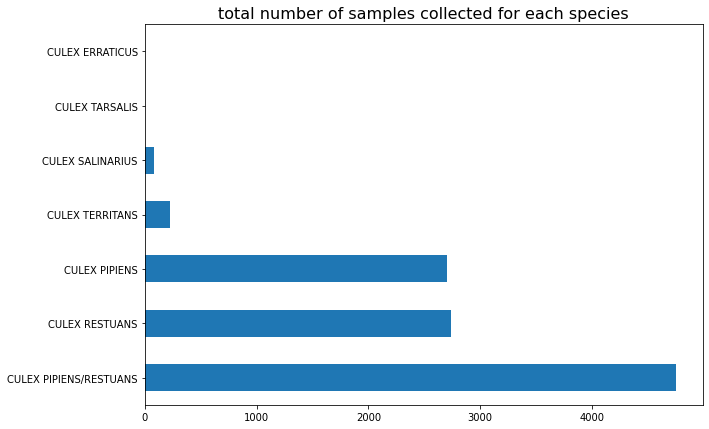

In [304]:
print(f'Number of unique mosquito species: {train.Species.nunique()}')
print('--------------------------------------------------------------')
print(f'Different species of mosquito and their normalised value counts: \n{train.Species.value_counts(normalize = True)}')
#train.Species.value_counts(normalize = True)

plt.figure(figsize = (10,7))
train.Species.value_counts().plot(kind = 'barh')
plt.title('total number of samples collected for each species', fontsize=16);

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


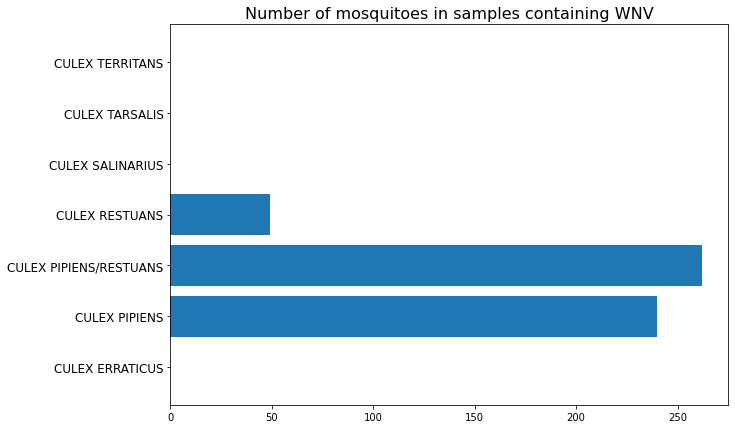

In [305]:
mos_wnv = train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)

mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,7))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

In [306]:
# make datetime columns
train['Year'] = train['Date'].apply(lambda x:x.year)
train['Month'] = train['Date'].apply(lambda x:x.month)
train['WeekofYear'] = train['Date'].apply(lambda x:x.weekofyear)
train['YearMonth'] = train['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# year 2007 - 2013
print(train.Year.value_counts().sort_index())

# data only from may - oct
print(train.Month.value_counts())

# week 22 - 41
print(train.WeekofYear.value_counts().sort_index())

# total number of weeks in dataset
print(train.WeekofYear.nunique())

2007    3811
2009    2249
2011    2054
2013    2392
Name: Year, dtype: int64
8     3751
7     2606
9     2218
6     1571
10     276
5       84
Name: Month, dtype: int64
22      84
23     383
24     321
25     332
26     504
27     105
28     981
29     591
30     738
31    1241
32     743
33     804
34     784
35     513
36     431
37     532
38     675
39     468
40     250
41      26
Name: WeekofYear, dtype: int64
20


In [307]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,WeekofYear,YearMonth
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,2007-05
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,2007-05
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,22,2007-05
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,22,2007-05
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,22,2007-05


### Trap information
---

There are 136 traps in the dataset of which it seems trap T900 located at O'hare international airport had the largest sample. As observed from recalling the rows for the T900 trap, there are 750 rows of entries with multiple entries on the same day. This is likely because of the cap of the number of mosquitoes for each record even when samples are collected on the same day. 

I will combine the counts for each day into a single record. Recalling the T900 trap information after consolidation shows the number of rows reducing from 750 to 154.


In [308]:
print(f'Number of traps : {train.Trap.nunique()}')

Number of traps : 136


T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

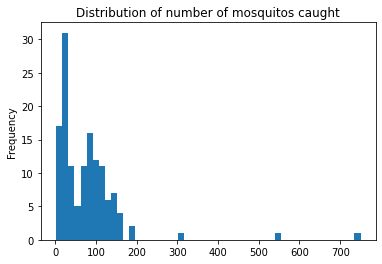

In [309]:
print(train.Trap.value_counts())
train.Trap.value_counts().plot(kind='hist', bins = 50)
plt.title("Distribution of number of mosquitos caught")
plt.tight_layout

In [310]:
train.loc[train['Trap'] == 'T900']

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,WeekofYear,YearMonth
3868,2009-05-28,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,30,0,2009,5,22,2009-05
3869,2009-05-28,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,4,0,2009,5,22,2009-05
3963,2009-06-03,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,22,0,2009,6,23,2009-06
3964,2009-06-03,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,0,2009,6,23,2009-06
3965,2009-06-03,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,21,0,2009,6,23,2009-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10485,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,4,0,2013,9,39,2013-09
10486,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,16,0,2013,9,39,2013-09
10487,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,9,0,2013,9,39,2013-09
10488,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,11,0,2013,9,39,2013-09


### Consolidating mosquito counts by date and mosquito species

In [311]:
train = train.groupby([col for col in train.columns if col not in ['NumMosquitos', \
                                                                'WnvPresent']]).sum()
train.reset_index(inplace=True)
train['WnvPresent'] = train['WnvPresent'].map(lambda x : 1 if x > 0 else 0)

train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,1,0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,2,0
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,2007,5,22,2007-05,1,0
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,2007,5,22,2007-05,1,0
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,2007,5,22,2007-05,1,0


In [312]:
train.loc[train['Trap'] == 'T900']

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent
2819,2009-05-28,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2009,5,22,2009-05,34,0
2921,2009-06-03,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2009,6,23,2009-06,254,0
2922,2009-06-03,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2009,6,23,2009-06,80,0
2989,2009-06-05,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2009,6,23,2009-06,10,0
2990,2009-06-05,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2009,6,23,2009-06,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8270,2013-09-12,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2013,9,37,2013-09,5,0
8373,2013-09-19,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2013,9,38,2013-09,76,0
8374,2013-09-19,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2013,9,38,2013-09,47,1
8460,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,2013,9,39,2013-09,37,0


### Univariate Analysis

In [313]:
# distribution plots (histogram, boxplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*2-1], fit = stats.norm)
        ax[i*2-1].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*2-1].tick_params(labelsize=12)
        ax[i*2-1].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*2-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*2-2].tick_params(labelsize=12)
        ax[i*2-2].set_xlabel(col, fontsize=14)

    plt.tight_layout()

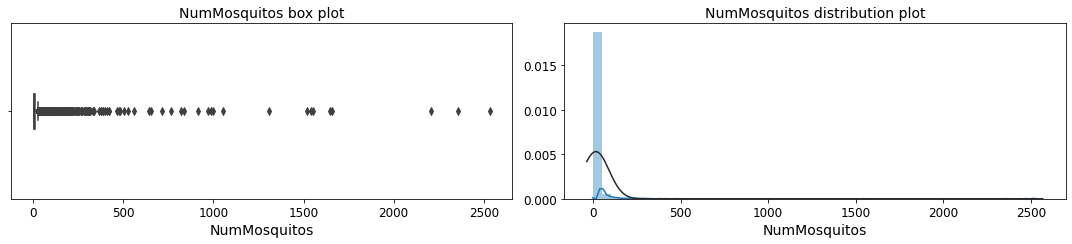

In [314]:
dist_plots(train, ['NumMosquitos'])

### Time-based Analysis

Looking at WNV occurance trends, it appears that WNV is seasonal occuring mostly between August and September as a yearly occurance. 2007, the start of our data marks the peak sampling of mosquitos with the largest number of mosquitos trapped per day. It is unsure as of now whether this was due to enhanced sampling efforts or the fact that there were an unseasonably large number of mosquitos. 
The start of the WNV season appears to accur in June, peaking in about August when condictions are at its hottest in summer before going down again. WNV occurance appears to be lower in 2009 and 2011.

In [315]:
# Create new datetime columns
train['Year'] = train['Date'].apply(lambda x:x.year)
train['Month'] = train['Date'].apply(lambda x:x.month)
train['WeekofYear'] = train['Date'].apply(lambda x:x.weekofyear)
train['YearMonth'] = train['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

train.head(3)
# # year 2007 - 2013
# print(train.Year.value_counts().sort_index())

# # data only from may - oct
# print(train.Month.value_counts())

# # week 22 - 41
# print(train.WeekofYear.value_counts().sort_index())

# # total number of weeks in dataset
# print(train.WeekofYear.nunique())

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,1,0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,2,0
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,2007,5,22,2007-05,1,0


In [316]:
train.groupby(['Year', 'Date', 'Latitude', 'Longitude']).count()[['WnvPresent']]

WnvPresent
Year Date       Latitude  Longitude             
2007 2007-05-29 41.688324 -87.676709           2
                41.720848 -87.666014           1
                41.731922 -87.677512           2
                41.732984 -87.649642           1
                41.862292 -87.648860           1
...                                          ...
2013 2013-09-26 41.987280 -87.666066           1
                41.991429 -87.747113           1
                41.992478 -87.862995           1
                42.008314 -87.777921           1
                42.009876 -87.807277           1

[4616 rows x 1 columns]

In [317]:
# get number of unique traps sampled per year
year = train.groupby(['Year','Date','Latitude','Longitude']).count()[['Species']]
year = year.reset_index()

# total number of unique traps sampled per year
year.Year.value_counts().sort_index()

2007    1459
2009    1006
2011     988
2013    1163
Name: Year, dtype: int64

No handles with labels found to put in legend.


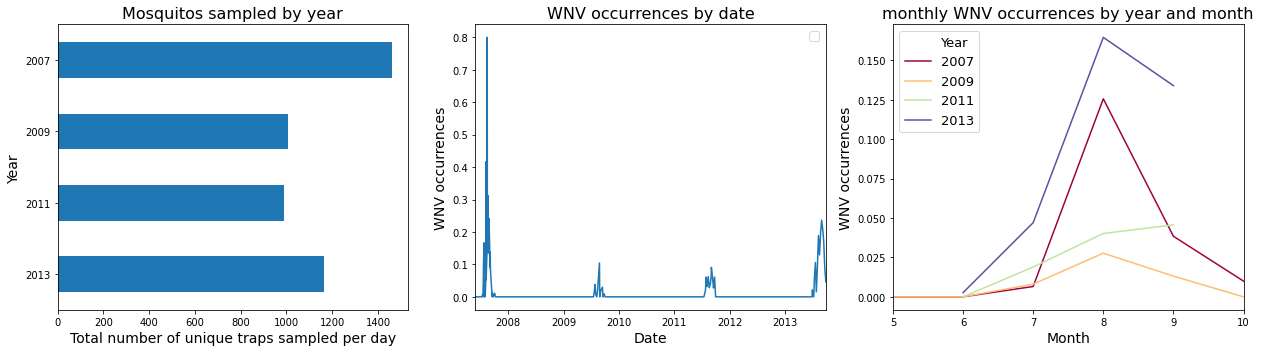

In [318]:
fig, ax = plt.subplots(ncols = 3, figsize=(18,5))

# plot sampling efforts by year
year.Year.value_counts().sort_index(ascending=False).plot(kind = 'barh', ax = ax[0])
ax[0].set_title('Mosquitos sampled by year', fontsize=16)
ax[0].set_ylabel('Year',fontsize=14)
ax[0].set_xlabel('Total number of unique traps sampled per day',fontsize=14)


# plot WNV occurrence by date
wnv = train[['Date','WnvPresent','Year','Month']]
sns.lineplot(x = 'Date', y = 'WnvPresent', data = wnv, ci = None, 
             legend = 'full', palette = 'Spectral', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('WNV occurrences by date', fontsize=16)
ax[1].set_xlabel('Date',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)
ax[1].set_xlim(wnv.Date.min(), wnv.Date.max())

# plot WNV occurrence by month and year
wnv = train[['Date','WnvPresent','Year','Month']]
sns.lineplot(x = wnv.Month,y = 'WnvPresent', data = wnv, hue = 'Year', ci = None, 
             legend = 'full', palette = 'Spectral', ax = ax[2])
ax[2].legend(fontsize = 13)
ax[2].set_title('monthly WNV occurrences by year and month', fontsize=16)
ax[2].set_xlabel('Month',fontsize=14)
ax[2].set_ylabel('WNV occurrences',fontsize=14)
ax[2].set_xlim(wnv.Month.min(), wnv.Month.max())
plt.tight_layout()

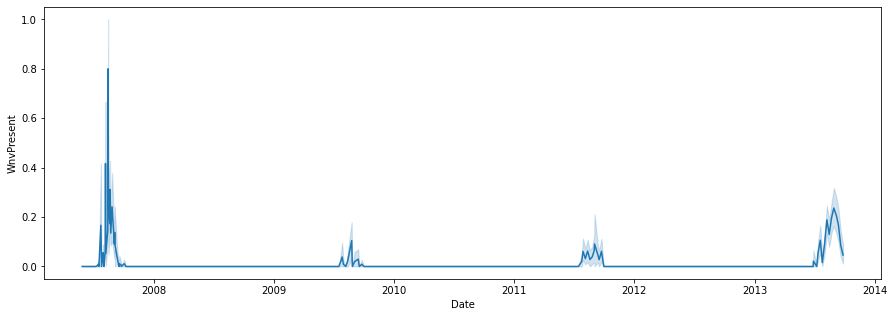

In [319]:
# plot WNV occurrence by date
plt.figure(figsize = (15,5))
sns.lineplot(x = 'Date', y = 'WnvPresent', data = wnv )

### Visualising geospatial data
___

The availability of Latitude and Longitudinal data means we can conveniently use the geopandas, descartes and shapely packages in order to visualise trap locations and locations of mosquitos that test positve/negative for WNV. In combination with datetime, we are able to paint an accurate picture of how WNV propagates throughout the active months of June to October for the years 2007, 2009, 2011, 2013. 

The data corresponds with the graphs charted in the previous section, showing how WNV starts mostly in June, with isolated spots as the mosquitos begin their active cycle, peak in August/September before waning in October. 

In [320]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [321]:
street_map = gpd.read_file('../chicago_geodata/geo_export_55fcb48c-7621-4c8a-999c-9fb3c86e8950.shx')

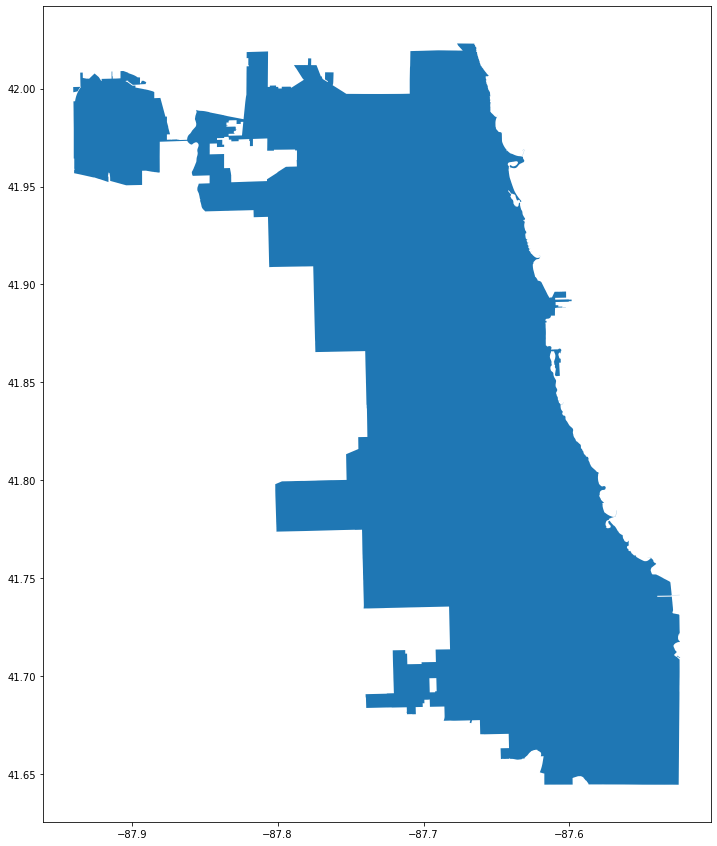

In [322]:
fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)

In [323]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip (train["Longitude"], train["Latitude"])]

In [324]:
geometry[:3]

In [325]:
geo_df = gpd.GeoDataFrame(train, #Specify dataset
                          crs = crs, # Specify coordinate referencing system
                          geometry = geometry #Specify the geometry list
)

/Users/leonard/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [326]:
geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8475 non-null   datetime64[ns]
 1   Address                 8475 non-null   object        
 2   Species                 8475 non-null   object        
 3   Block                   8475 non-null   int64         
 4   Street                  8475 non-null   object        
 5   Trap                    8475 non-null   object        
 6   AddressNumberAndStreet  8475 non-null   object        
 7   Latitude                8475 non-null   float64       
 8   Longitude               8475 non-null   float64       
 9   AddressAccuracy         8475 non-null   int64         
 10  Year                    8475 non-null   int64         
 11  Month                   8475 non-null   int64         
 12  WeekofYear              8475 non-null   

In [327]:
geo_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent,geometry
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,1,0,POINT (-87.65422 41.86711)
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,2,0,POINT (-87.65422 41.86711)
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,2007,5,22,2007-05,1,0,POINT (-87.64886 41.86229)
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,2007,5,22,2007-05,1,0,POINT (-87.65523 41.89628)
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,2007,5,22,2007-05,1,0,POINT (-87.76089 41.90765)


In [328]:
geo_df.set_index('Date', inplace=True)
geo_df.sort_index(inplace=True)

In [329]:
geo_df['2013']

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent,geometry
Date,,,,,,,,,,,,,,,,
2013-06-07,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX PIPIENS/RESTUANS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,2013,6,23,2013-06,2,0,POINT (-87.60088 41.77322)
2013-06-07,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX RESTUANS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,2013,6,23,2013-06,1,0,POINT (-87.60088 41.77322)
2013-06-07,"1000 North Central Park Avenue, Chicago, IL 60...",CULEX RESTUANS,10,N CENTRAL PARK DR,T030,"1000 N CENTRAL PARK DR, Chicago, IL",41.899230,-87.716788,9,2013,6,23,2013-06,10,0,POINT (-87.71679 41.89923)
2013-06-07,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2013,6,23,2013-06,2,0,POINT (-87.65422 41.86711)
2013-06-07,"1100 South California Avenue, Chicago, IL 6061...",CULEX RESTUANS,11,S CALIFORNIA,T047,"1100 S CALIFORNIA, Chicago, IL",41.868142,-87.696269,9,2013,6,23,2013-06,2,0,POINT (-87.69627 41.86814)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,"South Stony Island Avenue, Chicago, IL, USA",CULEX PIPIENS,10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,2013,9,39,2013-09,6,0,POINT (-87.58541 41.72647)
2013-09-26,"South Stony Island Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,2013,9,39,2013-09,4,0,POINT (-87.58541 41.72647)
2013-09-26,"South Vincennes Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,10,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.649970,5,2013,9,39,2013-09,4,0,POINT (-87.64997 41.72320)


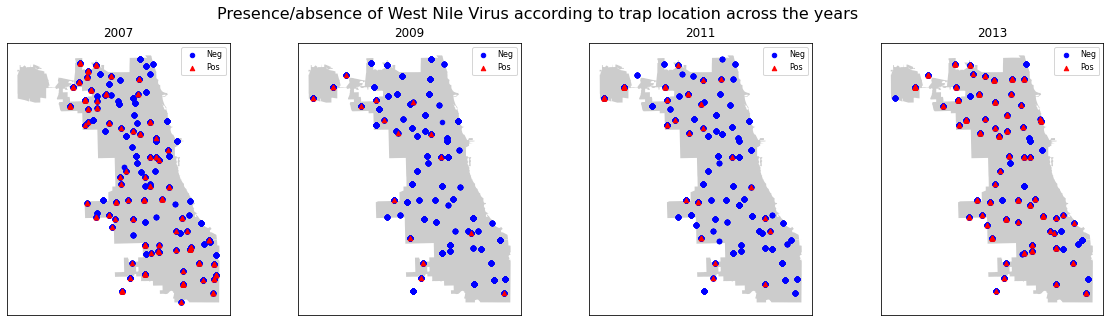

In [330]:
fig,  ax = plt.subplots(ncols = 4, figsize = (20,5))

fig.suptitle('Presence/absence of West Nile Virus according to trap location across the years', fontsize=16)

geo_df_2007 = geo_df['2007']
street_map.plot(ax = ax[0], alpha =0.4, color = 'grey')
geo_df_2007[geo_df_2007['WnvPresent']==0].plot(ax = ax[0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007[geo_df_2007['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0].legend(prop={'size':8})
ax[0].set_title('2007')
ax[0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009 = geo_df['2009']
street_map.plot(ax = ax[1], alpha =0.4, color = 'grey')
geo_df_2009[geo_df_2009['WnvPresent']==0].plot(ax = ax[1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009[geo_df_2009['WnvPresent']==1].plot(ax = ax[1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1].legend(prop={'size':8})
ax[1].set_title('2009')
ax[1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011 = geo_df['2011']
street_map.plot(ax = ax[2], alpha =0.4, color = 'grey')
geo_df_2011[geo_df_2011['WnvPresent']==0].plot(ax = ax[2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011[geo_df_2011['WnvPresent']==1].plot(ax = ax[2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2].legend(prop={'size':8})
ax[2].set_title('2011')
ax[2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013 = geo_df['2013']
street_map.plot(ax = ax[3], alpha =0.4, color = 'grey')
geo_df_2013[geo_df_2013['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013[geo_df_2013['WnvPresent']==1].plot(ax = ax[3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3].legend(prop={'size':8})
ax[3].set_title('2013')
ax[3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

plt.tight_layout;

In [331]:
geo_df['2009-06']

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent,geometry
Date,,,,,,,,,,,,,,,,
2009-06-02,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX PIPIENS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,2009,6,23,2009-06,1,0,POINT (-87.60088 41.77322)
2009-06-02,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX PIPIENS/RESTUANS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,2009,6,23,2009-06,4,0,POINT (-87.60088 41.77322)
2009-06-02,"1000 East 67th Street, Chicago, IL 60637, USA",CULEX RESTUANS,10,E 67TH ST,T073,"1000 E 67TH ST, Chicago, IL",41.773215,-87.600880,8,2009,6,23,2009-06,5,0,POINT (-87.60088 41.77322)
2009-06-02,"1000 North Central Park Avenue, Chicago, IL 60...",CULEX PIPIENS,10,N CENTRAL PARK DR,T030,"1000 N CENTRAL PARK DR, Chicago, IL",41.899230,-87.716788,9,2009,6,23,2009-06,1,0,POINT (-87.71679 41.89923)
2009-06-02,"1000 North Central Park Avenue, Chicago, IL 60...",CULEX PIPIENS/RESTUANS,10,N CENTRAL PARK DR,T030,"1000 N CENTRAL PARK DR, Chicago, IL",41.899230,-87.716788,9,2009,6,23,2009-06,2,0,POINT (-87.71679 41.89923)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-29,"Ohare Court, Bensenville, IL 60106, USA",CULEX PIPIENS/RESTUANS,10,W OHARE,T903,"1000 W OHARE, Chicago, IL",41.957799,-87.930995,5,2009,6,27,2009-06,7,0,POINT (-87.93099 41.95780)
2009-06-29,"South Brandon Avenue, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,13,S BRANDON,T209,"1300 S BRANDON, Chicago, IL",41.740641,-87.546587,5,2009,6,27,2009-06,1,0,POINT (-87.54659 41.74064)
2009-06-29,"South Brandon Avenue, Chicago, IL 60617, USA",CULEX RESTUANS,13,S BRANDON,T209,"1300 S BRANDON, Chicago, IL",41.740641,-87.546587,5,2009,6,27,2009-06,3,0,POINT (-87.54659 41.74064)


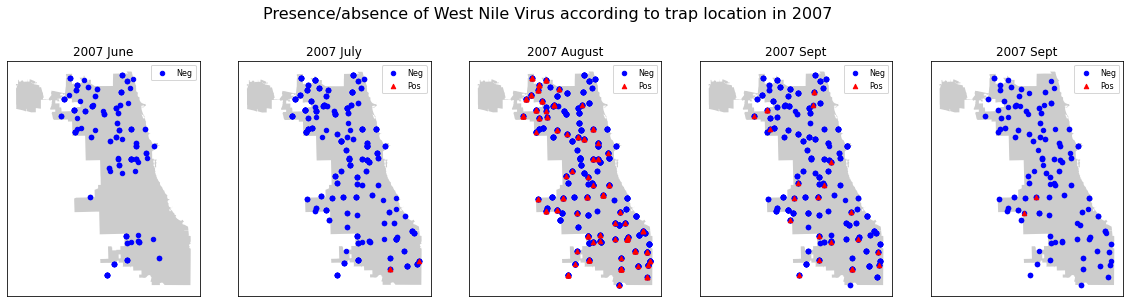

In [332]:
fig,  ax = plt.subplots(ncols = 5, figsize = (20,5))

fig.suptitle('Presence/absence of West Nile Virus according to trap location in 2007', fontsize=16)

geo_df_2007_06 = geo_df['2007-06']
street_map.plot(ax = ax[0], alpha =0.4, color = 'grey')
geo_df_2007_06[geo_df_2007_06['WnvPresent']==0].plot(ax = ax[0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2007_06[geo_df_2007_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0].legend(prop={'size':8})
ax[0].set_title('2007 June')
ax[0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_07 = geo_df['2007-07']
street_map.plot(ax = ax[1], alpha =0.4, color = 'grey')
geo_df_2007_07[geo_df_2007_07['WnvPresent']==0].plot(ax = ax[1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_07[geo_df_2007_07['WnvPresent']==1].plot(ax = ax[1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1].legend(prop={'size':8})
ax[1].set_title('2007 July')
ax[1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_08 = geo_df['2007-08']
street_map.plot(ax = ax[2], alpha =0.4, color = 'grey')
geo_df_2007_08[geo_df_2007_08['WnvPresent']==0].plot(ax = ax[2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_08[geo_df_2007_08['WnvPresent']==1].plot(ax = ax[2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2].legend(prop={'size':8})
ax[2].set_title('2007 August')
ax[2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_09 = geo_df['2007-09']
street_map.plot(ax = ax[3], alpha =0.4, color = 'grey')
geo_df_2007_09[geo_df_2007_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_09[geo_df_2007_09['WnvPresent']==1].plot(ax = ax[3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3].legend(prop={'size':8})
ax[3].set_title('2007 Sept')
ax[3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_10 = geo_df['2007-10']
street_map.plot(ax = ax[4], alpha =0.4, color = 'grey')
geo_df_2007_10[geo_df_2007_10['WnvPresent']==0].plot(ax = ax[4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_10[geo_df_2007_10['WnvPresent']==1].plot(ax = ax[4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[4].legend(prop={'size':8})
ax[4].set_title('2007 Sept')
ax[4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


plt.tight_layout;

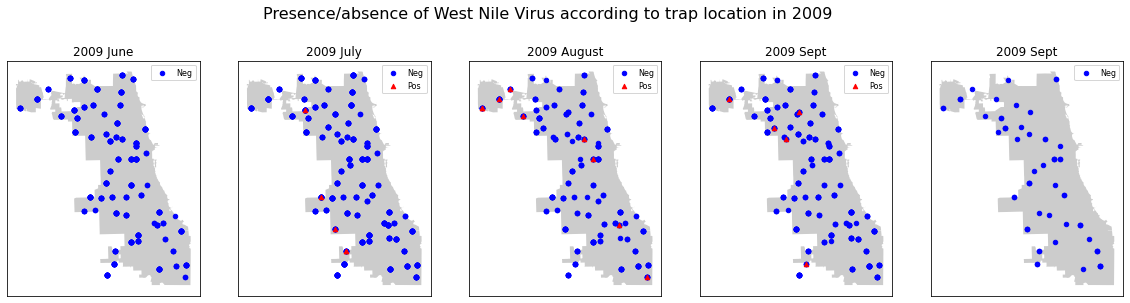

In [333]:
fig,  ax = plt.subplots(ncols = 5, figsize = (20,5))

fig.suptitle('Presence/absence of West Nile Virus according to trap location in 2009', fontsize=16)

geo_df_2009_06 = geo_df['2009-06']
street_map.plot(ax = ax[0], alpha =0.4, color = 'grey')
geo_df_2009_06[geo_df_2009_06['WnvPresent']==0].plot(ax = ax[0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_06[geo_df_2009_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0].legend(prop={'size':8})
ax[0].set_title('2009 June')
ax[0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_07 = geo_df['2009-07']
street_map.plot(ax = ax[1], alpha =0.4, color = 'grey')
geo_df_2009_07[geo_df_2009_07['WnvPresent']==0].plot(ax = ax[1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_07[geo_df_2009_07['WnvPresent']==1].plot(ax = ax[1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1].legend(prop={'size':8})
ax[1].set_title('2009 July')
ax[1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_08 = geo_df['2009-08']
street_map.plot(ax = ax[2], alpha =0.4, color = 'grey')
geo_df_2009_08[geo_df_2009_08['WnvPresent']==0].plot(ax = ax[2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_08[geo_df_2009_08['WnvPresent']==1].plot(ax = ax[2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2].legend(prop={'size':8})
ax[2].set_title('2009 August')
ax[2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_09 = geo_df['2009-09']
street_map.plot(ax = ax[3], alpha =0.4, color = 'grey')
geo_df_2009_09[geo_df_2009_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_09[geo_df_2009_09['WnvPresent']==1].plot(ax = ax[3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3].legend(prop={'size':8})
ax[3].set_title('2009 Sept')
ax[3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_10 = geo_df['2009-10']
street_map.plot(ax = ax[4], alpha =0.4, color = 'grey')
geo_df_2009_10[geo_df_2009_10['WnvPresent']==0].plot(ax = ax[4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_10[geo_df_2009_10['WnvPresent']==1].plot(ax = ax[4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[4].legend(prop={'size':8})
ax[4].set_title('2009 Sept')
ax[4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False)

plt.tight_layout;

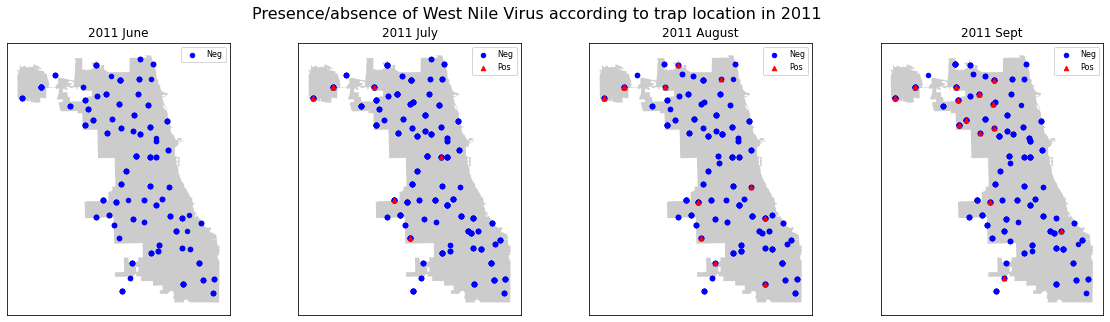

In [334]:
fig,  ax = plt.subplots(ncols = 4, figsize = (20,5))

fig.suptitle('Presence/absence of West Nile Virus according to trap location in 2011', fontsize=16)

geo_df_2011_06 = geo_df['2011-06']
street_map.plot(ax = ax[0], alpha =0.4, color = 'grey')
geo_df_2011_06[geo_df_2011_06['WnvPresent']==0].plot(ax = ax[0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_06[geo_df_2011_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0].legend(prop={'size':8})
ax[0].set_title('2011 June')
ax[0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_07 = geo_df['2011-07']
street_map.plot(ax = ax[1], alpha =0.4, color = 'grey')
geo_df_2011_07[geo_df_2011_07['WnvPresent']==0].plot(ax = ax[1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_07[geo_df_2011_07['WnvPresent']==1].plot(ax = ax[1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1].legend(prop={'size':8})
ax[1].set_title('2011 July')
ax[1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_08 = geo_df['2011-08']
street_map.plot(ax = ax[2], alpha =0.4, color = 'grey')
geo_df_2011_08[geo_df_2011_08['WnvPresent']==0].plot(ax = ax[2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_08[geo_df_2011_08['WnvPresent']==1].plot(ax = ax[2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2].legend(prop={'size':8})
ax[2].set_title('2011 August')
ax[2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_09 = geo_df['2011-09']
street_map.plot(ax = ax[3], alpha =0.4, color = 'grey')
geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3].legend(prop={'size':8})
ax[3].set_title('2011 Sept')
ax[3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


plt.tight_layout;

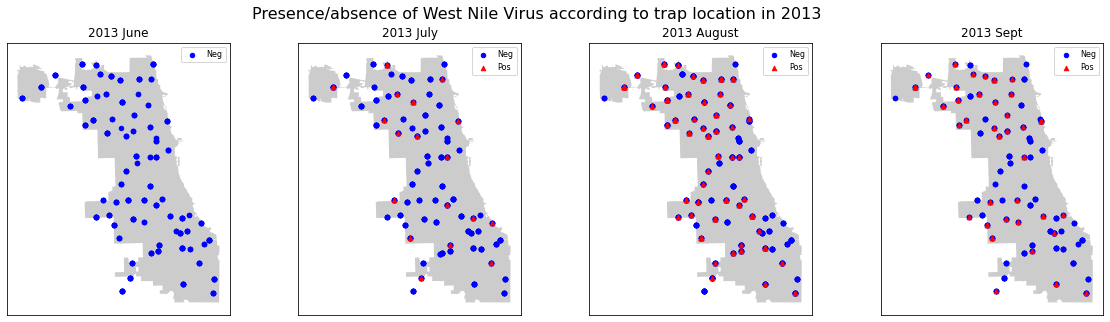

In [335]:
fig,  ax = plt.subplots(ncols = 4, figsize = (20,5))

fig.suptitle('Presence/absence of West Nile Virus according to trap location in 2013', fontsize=16)

geo_df_2013_06 = geo_df['2013-06']
street_map.plot(ax = ax[0], alpha =0.4, color = 'grey')
geo_df_2013_06[geo_df_2013_06['WnvPresent']==0].plot(ax = ax[0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2013_06[geo_df_2013_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0].legend(prop={'size':8})
ax[0].set_title('2013 June')
ax[0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_07 = geo_df['2013-07']
street_map.plot(ax = ax[1], alpha =0.4, color = 'grey')
geo_df_2013_07[geo_df_2013_07['WnvPresent']==0].plot(ax = ax[1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_07[geo_df_2013_07['WnvPresent']==1].plot(ax = ax[1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1].legend(prop={'size':8})
ax[1].set_title('2013 July')
ax[1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_08 = geo_df['2013-08']
street_map.plot(ax = ax[2], alpha =0.4, color = 'grey')
geo_df_2013_08[geo_df_2013_08['WnvPresent']==0].plot(ax = ax[2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_08[geo_df_2013_08['WnvPresent']==1].plot(ax = ax[2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2].legend(prop={'size':8})
ax[2].set_title('2013 August')
ax[2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3], alpha =0.4, color = 'grey')
geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3].legend(prop={'size':8})
ax[3].set_title('2013 Sept')
ax[3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 



plt.tight_layout;

In [336]:
### Geospatial plot of positive and negative WNV mosquitos caught charted via month and year

No handles with labels found to put in legend.
No handles with labels found to put in legend.


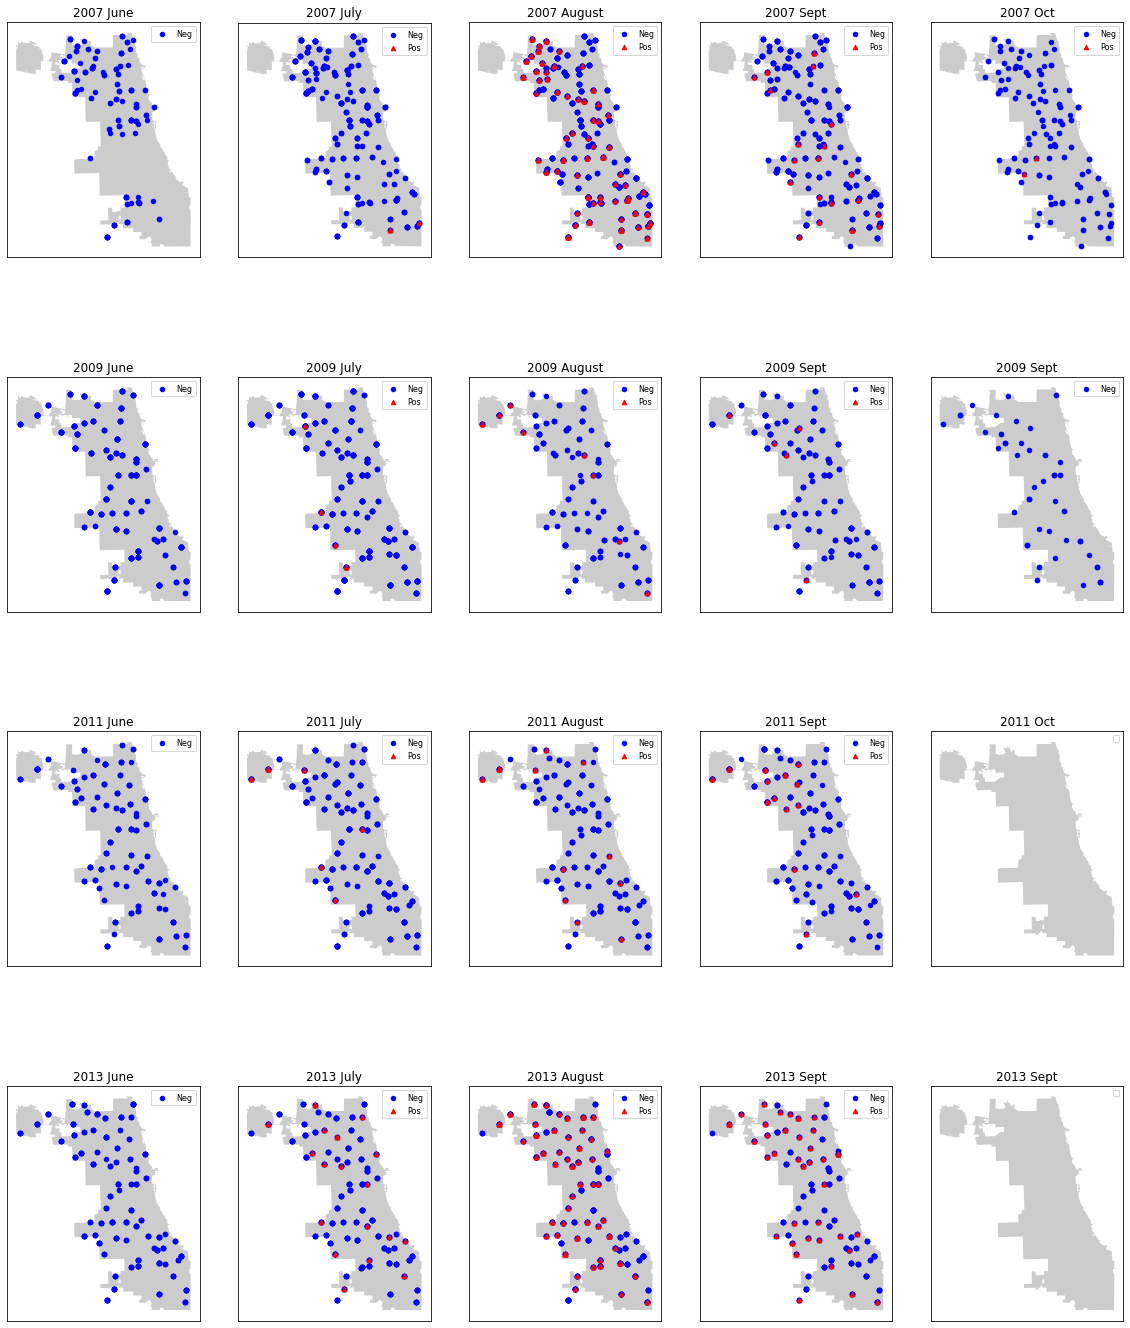

In [337]:
fig,  ax = plt.subplots(ncols = 5, nrows =4, figsize = (20,25))

#------------------------------------2007---------------------------------------------
geo_df_2007_06 = geo_df['2007-06']
street_map.plot(ax = ax[0,0], alpha =0.4, color = 'grey')
geo_df_2007_06[geo_df_2007_06['WnvPresent']==0].plot(ax = ax[0,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2007_06[geo_df_2007_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,0].legend(prop={'size':8})
ax[0,0].set_title('2007 June')
ax[0,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_07 = geo_df['2007-07']
street_map.plot(ax = ax[0,1], alpha =0.4, color = 'grey')
geo_df_2007_07[geo_df_2007_07['WnvPresent']==0].plot(ax = ax[0,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_07[geo_df_2007_07['WnvPresent']==1].plot(ax = ax[0,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,1].legend(prop={'size':8})
ax[0,1].set_title('2007 July')
ax[0,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_08 = geo_df['2007-08']
street_map.plot(ax = ax[0,2], alpha =0.4, color = 'grey')
geo_df_2007_08[geo_df_2007_08['WnvPresent']==0].plot(ax = ax[0,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_08[geo_df_2007_08['WnvPresent']==1].plot(ax = ax[0,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,2].legend(prop={'size':8})
ax[0,2].set_title('2007 August')
ax[0,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_09 = geo_df['2007-09']
street_map.plot(ax = ax[0,3], alpha =0.4, color = 'grey')
geo_df_2007_09[geo_df_2007_09['WnvPresent']==0].plot(ax = ax[0,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_09[geo_df_2007_09['WnvPresent']==1].plot(ax = ax[0,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,3].legend(prop={'size':8})
ax[0,3].set_title('2007 Sept')
ax[0,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_10 = geo_df['2007-10']
street_map.plot(ax = ax[0,4], alpha =0.4, color = 'grey')
geo_df_2007_10[geo_df_2007_10['WnvPresent']==0].plot(ax = ax[0,4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_10[geo_df_2007_10['WnvPresent']==1].plot(ax = ax[0,4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,4].legend(prop={'size':8})
ax[0,4].set_title('2007 Oct')
ax[0,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

#------------------------------------2009---------------------------------------------

geo_df_2009_06 = geo_df['2009-06']
street_map.plot(ax = ax[1,0], alpha =0.4, color = 'grey')
geo_df_2009_06[geo_df_2009_06['WnvPresent']==0].plot(ax = ax[1,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_06[geo_df_2009_06['WnvPresent']==1].plot(ax = ax[1,0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,0].legend(prop={'size':8})
ax[1,0].set_title('2009 June')
ax[1,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_07 = geo_df['2009-07']
street_map.plot(ax = ax[1,1], alpha =0.4, color = 'grey')
geo_df_2009_07[geo_df_2009_07['WnvPresent']==0].plot(ax = ax[1,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_07[geo_df_2009_07['WnvPresent']==1].plot(ax = ax[1,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,1].legend(prop={'size':8})
ax[1,1].set_title('2009 July')
ax[1,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_08 = geo_df['2009-08']
street_map.plot(ax = ax[1,2], alpha =0.4, color = 'grey')
geo_df_2009_08[geo_df_2009_08['WnvPresent']==0].plot(ax = ax[1,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_08[geo_df_2009_08['WnvPresent']==1].plot(ax = ax[1,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,2].legend(prop={'size':8})
ax[1,2].set_title('2009 August')
ax[1,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_09 = geo_df['2009-09']
street_map.plot(ax = ax[1,3], alpha =0.4, color = 'grey')
geo_df_2009_09[geo_df_2009_09['WnvPresent']==0].plot(ax = ax[1,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_09[geo_df_2009_09['WnvPresent']==1].plot(ax = ax[1,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,3].legend(prop={'size':8})
ax[1,3].set_title('2009 Sept')
ax[1,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


geo_df_2009_10 = geo_df['2009-10']
street_map.plot(ax = ax[1,4], alpha =0.4, color = 'grey')
geo_df_2009_10[geo_df_2009_10['WnvPresent']==0].plot(ax = ax[1,4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_10[geo_df_2009_10['WnvPresent']==1].plot(ax = ax[4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,4].legend(prop={'size':8})
ax[1,4].set_title('2009 Sept')
ax[1,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False)


#------------------------------------2011---------------------------------------------

geo_df_2011_06 = geo_df['2011-06']
street_map.plot(ax = ax[2,0], alpha =0.4, color = 'grey')
geo_df_2011_06[geo_df_2011_06['WnvPresent']==0].plot(ax = ax[2,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_06[geo_df_2011_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,0].legend(prop={'size':8})
ax[2,0].set_title('2011 June')
ax[2,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_07 = geo_df['2011-07']
street_map.plot(ax = ax[2,1], alpha =0.4, color = 'grey')
geo_df_2011_07[geo_df_2011_07['WnvPresent']==0].plot(ax = ax[2,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_07[geo_df_2011_07['WnvPresent']==1].plot(ax = ax[2,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,1].legend(prop={'size':8})
ax[2,1].set_title('2011 July')
ax[2,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_08 = geo_df['2011-08']
street_map.plot(ax = ax[2,2], alpha =0.4, color = 'grey')
geo_df_2011_08[geo_df_2011_08['WnvPresent']==0].plot(ax = ax[2,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_08[geo_df_2011_08['WnvPresent']==1].plot(ax = ax[2,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,2].legend(prop={'size':8})
ax[2,2].set_title('2011 August')
ax[2,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_09 = geo_df['2011-09']
street_map.plot(ax = ax[2,3], alpha =0.4, color = 'grey')
geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[2,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[2,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,3].legend(prop={'size':8})
ax[2,3].set_title('2011 Sept')
ax[2,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_09 = geo_df['2011-09']
street_map.plot(ax = ax[2,4], alpha =0.4, color = 'grey')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[2,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[2,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,4].legend(prop={'size':8})
ax[2,4].set_title('2011 Oct')
ax[2,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

#------------------------------------2013---------------------------------------------

geo_df_2013_06 = geo_df['2013-06']
street_map.plot(ax = ax[3,0], alpha =0.4, color = 'grey')
geo_df_2013_06[geo_df_2013_06['WnvPresent']==0].plot(ax = ax[3,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2013_06[geo_df_2013_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,0].legend(prop={'size':8})
ax[3,0].set_title('2013 June')
ax[3,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_07 = geo_df['2013-07']
street_map.plot(ax = ax[3,1], alpha =0.4, color = 'grey')
geo_df_2013_07[geo_df_2013_07['WnvPresent']==0].plot(ax = ax[3,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_07[geo_df_2013_07['WnvPresent']==1].plot(ax = ax[3,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,1].legend(prop={'size':8})
ax[3,1].set_title('2013 July')
ax[3,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_08 = geo_df['2013-08']
street_map.plot(ax = ax[3,2], alpha =0.4, color = 'grey')
geo_df_2013_08[geo_df_2013_08['WnvPresent']==0].plot(ax = ax[3,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_08[geo_df_2013_08['WnvPresent']==1].plot(ax = ax[3,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,2].legend(prop={'size':8})
ax[3,2].set_title('2013 August')
ax[3,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3,3], alpha =0.4, color = 'grey')
geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,3].legend(prop={'size':8})
ax[3,3].set_title('2013 Sept')
ax[3,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3,4], alpha =0.4, color = 'grey')
# geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
# geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,4].legend(prop={'size':8})
ax[3,4].set_title('2013 Sept')
ax[3,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


### Geospatial plot of positve WNV mosquitos caught charted via month and year

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


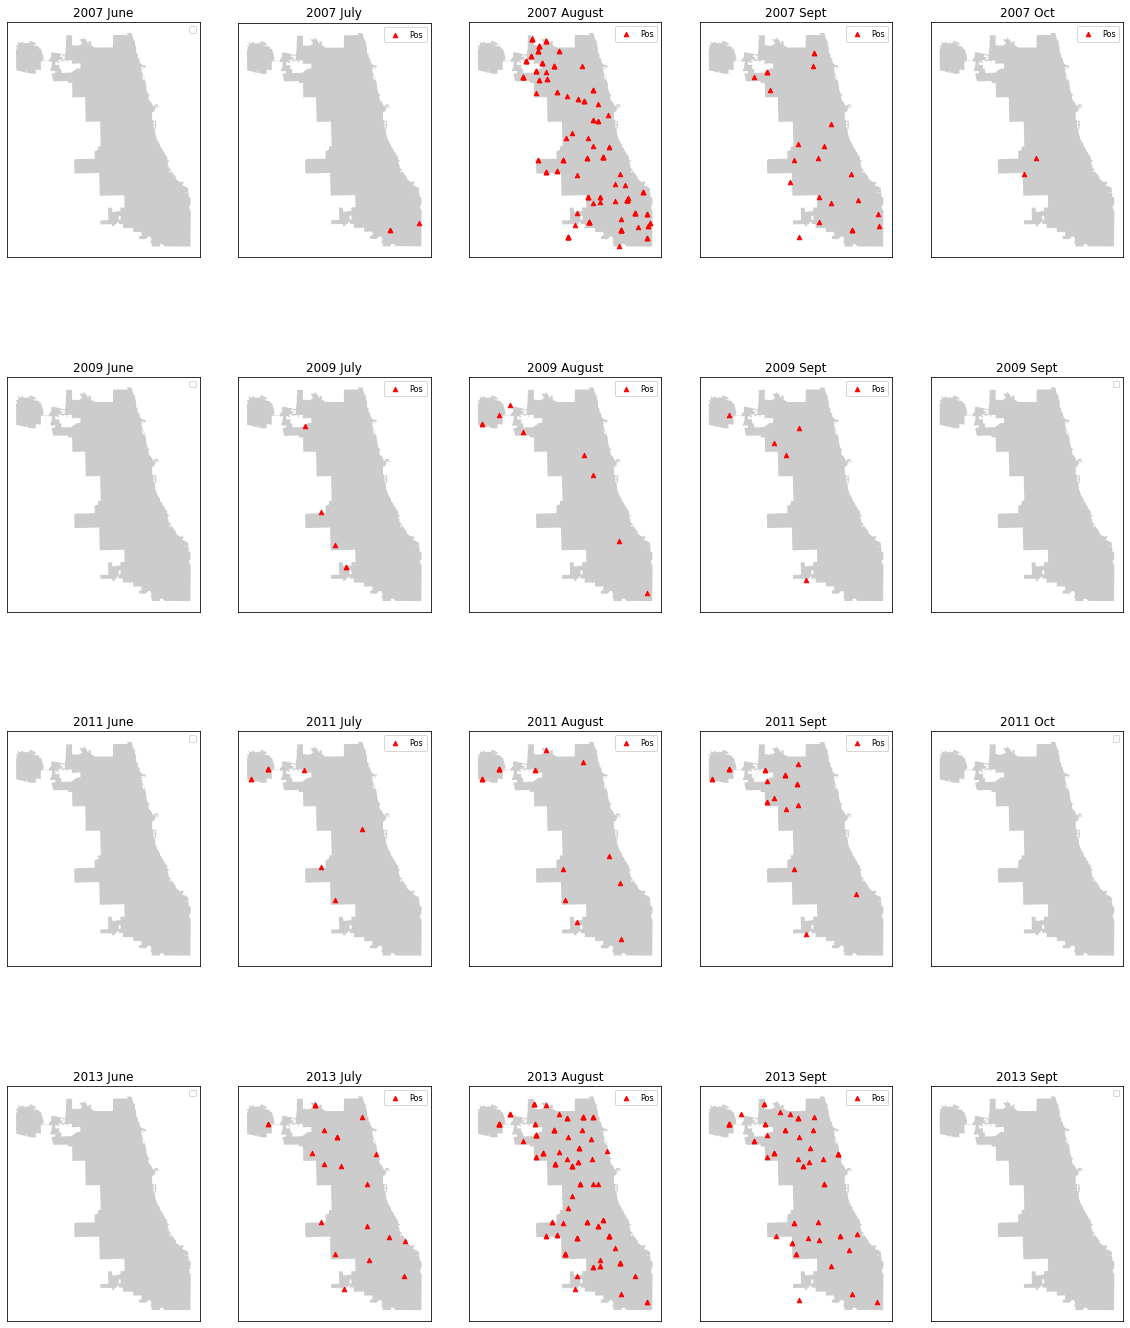

In [338]:
fig,  ax = plt.subplots(ncols = 5, nrows =4, figsize = (20,25))

#------------------------------------2007---------------------------------------------
geo_df_2007_06 = geo_df['2007-06']
street_map.plot(ax = ax[0,0], alpha =0.4, color = 'grey')
#geo_df_2007_06[geo_df_2007_06['WnvPresent']==0].plot(ax = ax[0,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2007_06[geo_df_2007_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,0].legend(prop={'size':8})
ax[0,0].set_title('2007 June')
ax[0,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_07 = geo_df['2007-07']
street_map.plot(ax = ax[0,1], alpha =0.4, color = 'grey')
#geo_df_2007_07[geo_df_2007_07['WnvPresent']==0].plot(ax = ax[0,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_07[geo_df_2007_07['WnvPresent']==1].plot(ax = ax[0,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,1].legend(prop={'size':8})
ax[0,1].set_title('2007 July')
ax[0,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_08 = geo_df['2007-08']
street_map.plot(ax = ax[0,2], alpha =0.4, color = 'grey')
#geo_df_2007_08[geo_df_2007_08['WnvPresent']==0].plot(ax = ax[0,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_08[geo_df_2007_08['WnvPresent']==1].plot(ax = ax[0,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,2].legend(prop={'size':8})
ax[0,2].set_title('2007 August')
ax[0,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_09 = geo_df['2007-09']
street_map.plot(ax = ax[0,3], alpha =0.4, color = 'grey')
#geo_df_2007_09[geo_df_2007_09['WnvPresent']==0].plot(ax = ax[0,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_09[geo_df_2007_09['WnvPresent']==1].plot(ax = ax[0,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,3].legend(prop={'size':8})
ax[0,3].set_title('2007 Sept')
ax[0,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_10 = geo_df['2007-10']
street_map.plot(ax = ax[0,4], alpha =0.4, color = 'grey')
#geo_df_2007_10[geo_df_2007_10['WnvPresent']==0].plot(ax = ax[0,4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_10[geo_df_2007_10['WnvPresent']==1].plot(ax = ax[0,4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,4].legend(prop={'size':8})
ax[0,4].set_title('2007 Oct')
ax[0,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

#------------------------------------2009---------------------------------------------

geo_df_2009_06 = geo_df['2009-06']
street_map.plot(ax = ax[1,0], alpha =0.4, color = 'grey')
#geo_df_2009_06[geo_df_2009_06['WnvPresent']==0].plot(ax = ax[1,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_06[geo_df_2009_06['WnvPresent']==1].plot(ax = ax[1,0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,0].legend(prop={'size':8})
ax[1,0].set_title('2009 June')
ax[1,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_07 = geo_df['2009-07']
street_map.plot(ax = ax[1,1], alpha =0.4, color = 'grey')
#geo_df_2009_07[geo_df_2009_07['WnvPresent']==0].plot(ax = ax[1,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_07[geo_df_2009_07['WnvPresent']==1].plot(ax = ax[1,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,1].legend(prop={'size':8})
ax[1,1].set_title('2009 July')
ax[1,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_08 = geo_df['2009-08']
street_map.plot(ax = ax[1,2], alpha =0.4, color = 'grey')
#geo_df_2009_08[geo_df_2009_08['WnvPresent']==0].plot(ax = ax[1,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_08[geo_df_2009_08['WnvPresent']==1].plot(ax = ax[1,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,2].legend(prop={'size':8})
ax[1,2].set_title('2009 August')
ax[1,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_09 = geo_df['2009-09']
street_map.plot(ax = ax[1,3], alpha =0.4, color = 'grey')
#geo_df_2009_09[geo_df_2009_09['WnvPresent']==0].plot(ax = ax[1,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_09[geo_df_2009_09['WnvPresent']==1].plot(ax = ax[1,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,3].legend(prop={'size':8})
ax[1,3].set_title('2009 Sept')
ax[1,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


geo_df_2009_10 = geo_df['2009-10']
street_map.plot(ax = ax[1,4], alpha =0.4, color = 'grey')
#geo_df_2009_10[geo_df_2009_10['WnvPresent']==0].plot(ax = ax[1,4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_10[geo_df_2009_10['WnvPresent']==1].plot(ax = ax[4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,4].legend(prop={'size':8})
ax[1,4].set_title('2009 Sept')
ax[1,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False)


#------------------------------------2011---------------------------------------------

geo_df_2011_06 = geo_df['2011-06']
street_map.plot(ax = ax[2,0], alpha =0.4, color = 'grey')
#geo_df_2011_06[geo_df_2011_06['WnvPresent']==0].plot(ax = ax[2,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_06[geo_df_2011_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,0].legend(prop={'size':8})
ax[2,0].set_title('2011 June')
ax[2,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_07 = geo_df['2011-07']
street_map.plot(ax = ax[2,1], alpha =0.4, color = 'grey')
#geo_df_2011_07[geo_df_2011_07['WnvPresent']==0].plot(ax = ax[2,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_07[geo_df_2011_07['WnvPresent']==1].plot(ax = ax[2,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,1].legend(prop={'size':8})
ax[2,1].set_title('2011 July')
ax[2,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_08 = geo_df['2011-08']
street_map.plot(ax = ax[2,2], alpha =0.4, color = 'grey')
#geo_df_2011_08[geo_df_2011_08['WnvPresent']==0].plot(ax = ax[2,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_08[geo_df_2011_08['WnvPresent']==1].plot(ax = ax[2,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,2].legend(prop={'size':8})
ax[2,2].set_title('2011 August')
ax[2,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_09 = geo_df['2011-09']
street_map.plot(ax = ax[2,3], alpha =0.4, color = 'grey')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[2,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[2,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,3].legend(prop={'size':8})
ax[2,3].set_title('2011 Sept')
ax[2,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_09 = geo_df['2011-09']
street_map.plot(ax = ax[2,4], alpha =0.4, color = 'grey')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[2,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[2,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,4].legend(prop={'size':8})
ax[2,4].set_title('2011 Oct')
ax[2,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

#------------------------------------2013---------------------------------------------

geo_df_2013_06 = geo_df['2013-06']
street_map.plot(ax = ax[3,0], alpha =0.4, color = 'grey')
#geo_df_2013_06[geo_df_2013_06['WnvPresent']==0].plot(ax = ax[3,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2013_06[geo_df_2013_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,0].legend(prop={'size':8})
ax[3,0].set_title('2013 June')
ax[3,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_07 = geo_df['2013-07']
street_map.plot(ax = ax[3,1], alpha =0.4, color = 'grey')
#geo_df_2013_07[geo_df_2013_07['WnvPresent']==0].plot(ax = ax[3,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_07[geo_df_2013_07['WnvPresent']==1].plot(ax = ax[3,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,1].legend(prop={'size':8})
ax[3,1].set_title('2013 July')
ax[3,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_08 = geo_df['2013-08']
street_map.plot(ax = ax[3,2], alpha =0.4, color = 'grey')
#geo_df_2013_08[geo_df_2013_08['WnvPresent']==0].plot(ax = ax[3,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_08[geo_df_2013_08['WnvPresent']==1].plot(ax = ax[3,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,2].legend(prop={'size':8})
ax[3,2].set_title('2013 August')
ax[3,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3,3], alpha =0.4, color = 'grey')
#geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,3].legend(prop={'size':8})
ax[3,3].set_title('2013 Sept')
ax[3,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3,4], alpha =0.4, color = 'grey')
# geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
# geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,4].legend(prop={'size':8})
ax[3,4].set_title('2013 Sept')
ax[3,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False)

### Summary of train data
---

The `train` set gives us a summary of mosquito infestations in the Chicago area and has revealed a number of things based on the sampling efforts of the mosquitos.

1. About 7 varieties of mosquitos exist that are capable of WNV transmission, however, only 3 major kinds of mosquitos C. pipiens, C. Restuans and C. Pipiens/Restuans have proven strong carriers of the WNV virus within the Chicago area in 2007, 2009, 2011 and 2013. They also make up more than 96% of the sampled of species provided

2. Based on time-based trends of WNV occurances, the WNV appears to exhibit strong annual seasonality trends starting in the month of July, peaking in August before waning in September and October. Interestingly enough, although mosquitos are sampled throughout the year, WNV appears only during these periods.

3. Geospatial plotting of the trapped mosquitos and reconciliation with the count of the number of mosquitos has shown that although mosquitos have been trapped over the entire locale of the Chicago area, the highest counts for trapped mosqitos have occured at the T900 trap at the O'Hare international airport. DUe to the way the data is organised, we are not able to see the extent of which the WNV virus has infiltrated a particular sample of mosquitos although one can make the assumption that the T900 trap probably has the highest proportion of WNV-infected mosquitos.


## Spray

The `Spray` dataset appears to be logs for spray activity in the Chicago region that captures the time and location of the spray. At first glance the `Spray` dataset appears to be a much smaller dataset compared to `train` with only four features. The main source of null values appears to be `time` which is a description of the time of which spraying took place at a certain Latitude and Longitude. It is unlikely that we will require such granularity of information and can consider dropping the column altogether. However, this requires further investigation before such a broad and violent treatment of the data should take place. There is a possibility that `time` might possibly be an indication for dosage of the spray.

In [339]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [340]:
basic_eda(spray, 'Spray information')

SPRAY INFORMATION

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object
-----



In [341]:
spray.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,14835.0,41.904828,0.104381,41.713925,41.785001,41.940075,41.980978,42.395983
Longitude,14835.0,-87.736690,0.067292,-88.096468,-87.794225,-87.727853,-87.694108,-87.586727


In [342]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [343]:
null_data = spray[spray.isnull().any(axis=1)]
null_data

,Date,Time,Latitude,Longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
...,...,...,...,...
1609,2011-09-07,NaN,41.995876,-87.811615
1610,2011-09-07,NaN,41.995972,-87.810271
1611,2011-09-07,NaN,41.995684,-87.810319
1612,2011-09-07,NaN,41.994724,-87.810415


### Exploring duplicated rows in Spray data

Looking deeper into the Spray data, there appears to be multiple duplicated rows that have been recorded as Spray logs for a single location. Although it can be argued that this might mean make a case for increased doses at a certain location, a single entry at "Latitude" = 41.986460 and "Longitude" = -87.794225 on 2011-09-07 has been repeated 541 times at 7:44:32 PM. It would be humanly impossible to spray a single area 541 times at the exact minute and second logged. 

This also makes up the majority of the duplicated rows (543 entries)

I hence posit that all NaN values in the `Time` feature are indeed errors in recording. Considering that it is unlikely we'll require the granularity of information that `Time` gives us, the column will be dropped.
Furthermore, as we have also established that duplicates in spray are purely the result of data collection error, we can safely drop those rows.

In [344]:
duplicated_spray = spray[spray.duplicated(keep=False)]

In [345]:
duplicated_spray.head(20)

,Date,Time,Latitude,Longitude
484,2011-09-07,7:43:40 PM,41.983917,-87.793088
485,2011-09-07,7:43:40 PM,41.983917,-87.793088
489,2011-09-07,7:44:32 PM,41.986460,-87.794225
490,2011-09-07,7:44:32 PM,41.986460,-87.794225
491,2011-09-07,7:44:32 PM,41.986460,-87.794225
492,2011-09-07,7:44:32 PM,41.986460,-87.794225
493,2011-09-07,7:44:32 PM,41.986460,-87.794225
494,2011-09-07,7:44:32 PM,41.986460,-87.794225
495,2011-09-07,7:44:32 PM,41.986460,-87.794225
496,2011-09-07,7:44:32 PM,41.986460,-87.794225


In [346]:
duplicated_spray.shape

(543, 4)

In [347]:
spray.loc[(spray["Date"] == "2011-09-07") & (spray["Latitude"]==41.986460) & (spray["Longitude"]==-87.794225)]

,Date,Time,Latitude,Longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.98646,-87.794225
1026,2011-09-07,7:44:32 PM,41.98646,-87.794225
1027,2011-09-07,7:44:32 PM,41.98646,-87.794225
1028,2011-09-07,7:44:32 PM,41.98646,-87.794225


In [348]:
#Drop all NaN values
spray.drop('Time', axis =1, inplace = True)

In [349]:
#Drop duplicated rows
print(f"Spray shape before drop: {spray.shape}")
spray = spray.drop_duplicates(keep='first')
print(f"New spray shape: {spray.shape}")

Spray shape before drop: (14835, 3)
New spray shape: (14294, 3)


In [350]:
spray.isnull().sum()

Date         0
Latitude     0
Longitude    0
dtype: int64

### Geospatial visualisation of spray data

Plotting the sprayed areas on a geopandas map has revealed further errors in recording in the 2011 data. Further examination shows that almost all the erroneous entries were made on 2011-08-29.	

In [351]:
spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [352]:
# Drop all erroneous entries from df
spray.drop(spray.index[0:95], inplace = True)

/Users/leonard/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [353]:
# Set index as date for easy referencing
spray.set_index('Date', inplace=True)
spray.sort_index(inplace=True)

In [354]:
# Cretae Geodata points for Spray information
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip (spray["Longitude"], spray["Latitude"])]

geo_spray = gpd.GeoDataFrame(spray, #Specify dataset
                          crs = crs, # Specify coordinate referencing system
                          geometry = geometry #Specify the geometry list
)

geo_spray.head()

/Users/leonard/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Latitude,Longitude,geometry
Date,,,
2011-09-07,41.981433,-87.787777,POINT (-87.78778 41.98143)
2011-09-07,41.980998,-87.787778,POINT (-87.78778 41.98100)
2011-09-07,41.980560,-87.787762,POINT (-87.78776 41.98056)
2011-09-07,41.980198,-87.787758,POINT (-87.78776 41.98020)
2011-09-07,41.979752,-87.787765,POINT (-87.78777 41.97975)


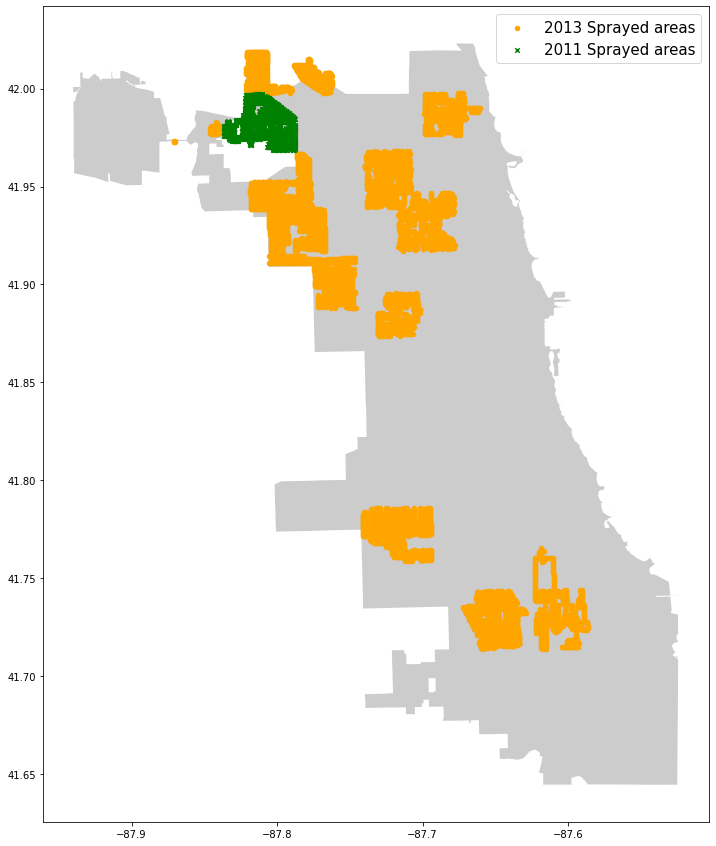

In [355]:
fig,  ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_spray['2013'].plot(ax = ax, markersize = 20, color ="orange", marker = 'o', label ='2013 Sprayed areas')
geo_spray['2011'].plot(ax = ax, markersize = 20, color ="green", marker = 'x', label ='2011 Sprayed areas')
plt.legend(prop ={'size': 15})

In [356]:
#Check for further errors
error_rows = geo_spray[(geo_spray['Latitude'] > 42.1) & (geo_spray['Longitude'] < -88.0)]

error_rows.head(96)

,Latitude,Longitude,geometry
Date,,,


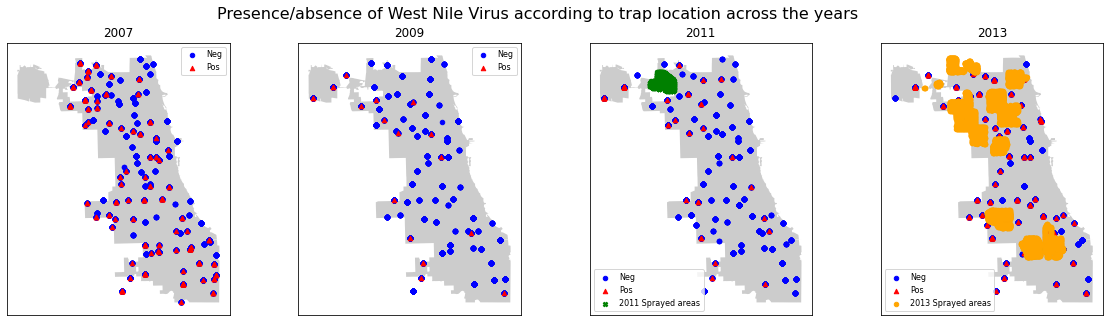

In [357]:
fig,  ax = plt.subplots(ncols = 4, figsize = (20,5))

fig.suptitle('Presence/absence of West Nile Virus according to trap location across the years', fontsize=16)

geo_df_2007 = geo_df['2007']
street_map.plot(ax = ax[0], alpha =0.4, color = 'grey')
geo_df_2007[geo_df_2007['WnvPresent']==0].plot(ax = ax[0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007[geo_df_2007['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0].legend(prop={'size':8})
ax[0].set_title('2007')
ax[0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009 = geo_df['2009']
street_map.plot(ax = ax[1], alpha =0.4, color = 'grey')
geo_df_2009[geo_df_2009['WnvPresent']==0].plot(ax = ax[1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009[geo_df_2009['WnvPresent']==1].plot(ax = ax[1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1].legend(prop={'size':8})
ax[1].set_title('2009')
ax[1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

spray_2011 = geo_spray['2011']
geo_df_2011 = geo_df['2011']
street_map.plot(ax = ax[2], alpha =0.4, color = 'grey')
geo_df_2011[geo_df_2011['WnvPresent']==0].plot(ax = ax[2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011[geo_df_2011['WnvPresent']==1].plot(ax = ax[2], markersize = 20, color ="red", marker = '^', label ='Pos')
spray_2011.plot(ax = ax[2], markersize = 20, color ="green", marker = 'X', label ='2011 Sprayed areas')
ax[2].legend(prop={'size':8})
ax[2].set_title('2011')
ax[2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013 = geo_df['2013']
street_map.plot(ax = ax[3], alpha =0.4, color = 'grey')
geo_df_2013[geo_df_2013['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013[geo_df_2013['WnvPresent']==1].plot(ax = ax[3], markersize = 20, color ="red", marker = '^', label ='Pos')
geo_spray['2013'].plot(ax = ax[3], markersize = 20, color ="orange", marker = 'o', label ='2013 Sprayed areas')
ax[3].legend(prop={'size':8})
ax[3].set_title('2013')
ax[3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

plt.tight_layout;

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


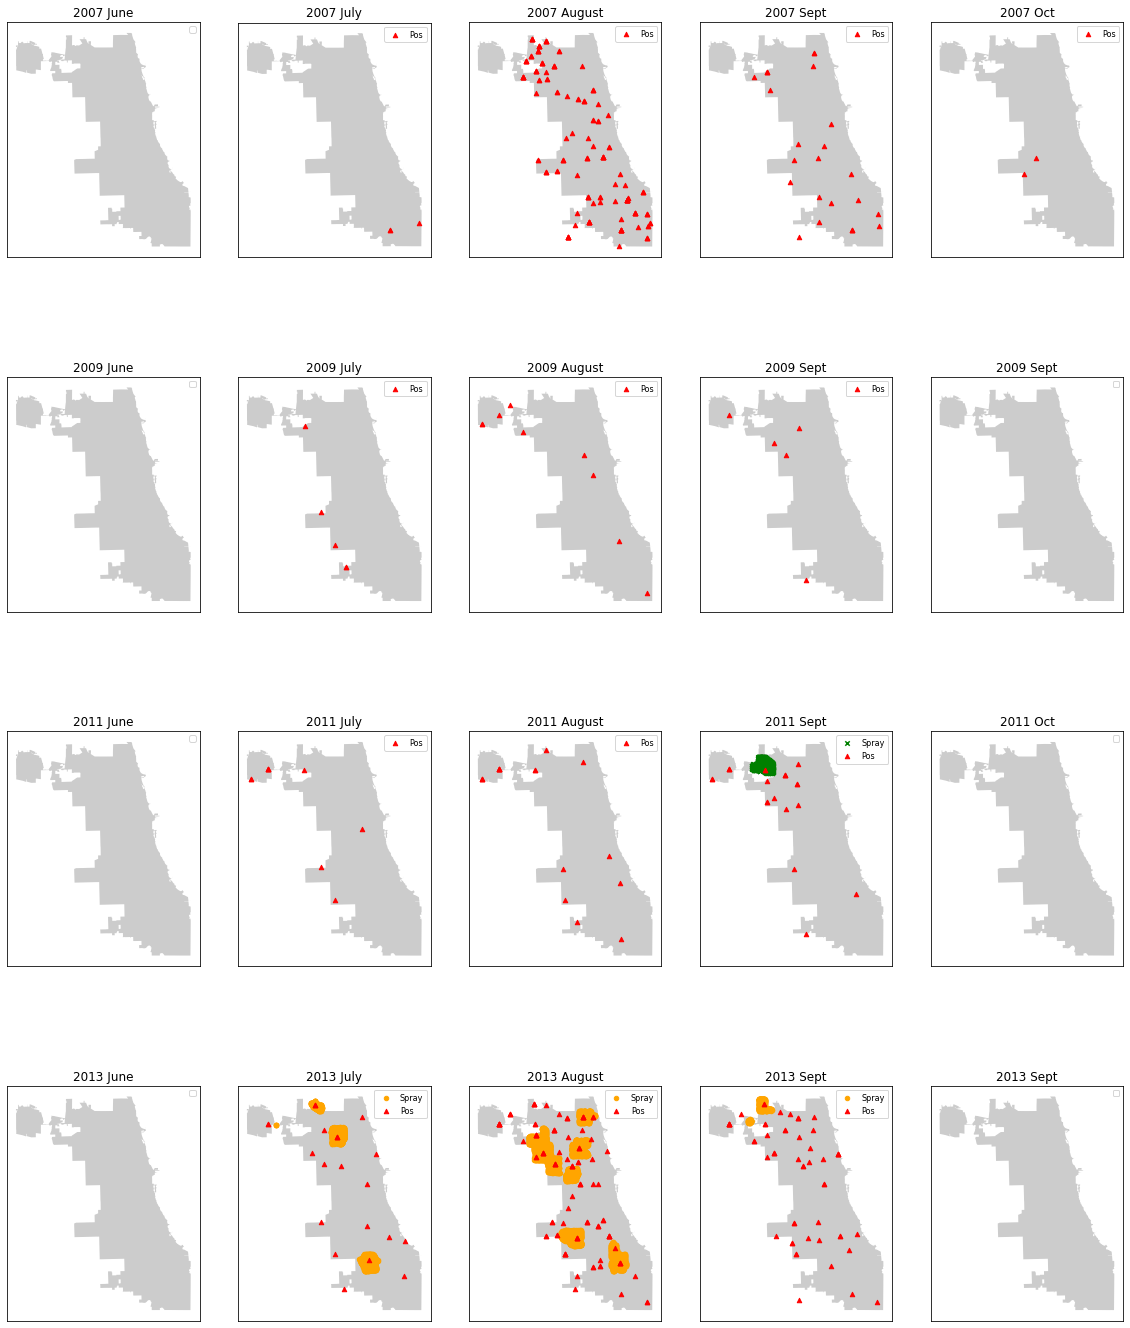

In [358]:
fig,  ax = plt.subplots(ncols = 5, nrows =4, figsize = (20,25))

#------------------------------------2007---------------------------------------------
geo_df_2007_06 = geo_df['2007-06']
street_map.plot(ax = ax[0,0], alpha =0.4, color = 'grey')
#geo_df_2007_06[geo_df_2007_06['WnvPresent']==0].plot(ax = ax[0,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2007_06[geo_df_2007_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,0].legend(prop={'size':8})
ax[0,0].set_title('2007 June')
ax[0,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_07 = geo_df['2007-07']
street_map.plot(ax = ax[0,1], alpha =0.4, color = 'grey')
#geo_df_2007_07[geo_df_2007_07['WnvPresent']==0].plot(ax = ax[0,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_07[geo_df_2007_07['WnvPresent']==1].plot(ax = ax[0,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,1].legend(prop={'size':8})
ax[0,1].set_title('2007 July')
ax[0,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_08 = geo_df['2007-08']
street_map.plot(ax = ax[0,2], alpha =0.4, color = 'grey')
#geo_df_2007_08[geo_df_2007_08['WnvPresent']==0].plot(ax = ax[0,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_08[geo_df_2007_08['WnvPresent']==1].plot(ax = ax[0,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,2].legend(prop={'size':8})
ax[0,2].set_title('2007 August')
ax[0,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_09 = geo_df['2007-09']
street_map.plot(ax = ax[0,3], alpha =0.4, color = 'grey')
#geo_df_2007_09[geo_df_2007_09['WnvPresent']==0].plot(ax = ax[0,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_09[geo_df_2007_09['WnvPresent']==1].plot(ax = ax[0,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,3].legend(prop={'size':8})
ax[0,3].set_title('2007 Sept')
ax[0,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2007_10 = geo_df['2007-10']
street_map.plot(ax = ax[0,4], alpha =0.4, color = 'grey')
#geo_df_2007_10[geo_df_2007_10['WnvPresent']==0].plot(ax = ax[0,4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2007_10[geo_df_2007_10['WnvPresent']==1].plot(ax = ax[0,4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[0,4].legend(prop={'size':8})
ax[0,4].set_title('2007 Oct')
ax[0,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

#------------------------------------2009---------------------------------------------

geo_df_2009_06 = geo_df['2009-06']
street_map.plot(ax = ax[1,0], alpha =0.4, color = 'grey')
#geo_df_2009_06[geo_df_2009_06['WnvPresent']==0].plot(ax = ax[1,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_06[geo_df_2009_06['WnvPresent']==1].plot(ax = ax[1,0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,0].legend(prop={'size':8})
ax[1,0].set_title('2009 June')
ax[1,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_07 = geo_df['2009-07']
street_map.plot(ax = ax[1,1], alpha =0.4, color = 'grey')
#geo_df_2009_07[geo_df_2009_07['WnvPresent']==0].plot(ax = ax[1,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_07[geo_df_2009_07['WnvPresent']==1].plot(ax = ax[1,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,1].legend(prop={'size':8})
ax[1,1].set_title('2009 July')
ax[1,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_08 = geo_df['2009-08']
street_map.plot(ax = ax[1,2], alpha =0.4, color = 'grey')
#geo_df_2009_08[geo_df_2009_08['WnvPresent']==0].plot(ax = ax[1,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_08[geo_df_2009_08['WnvPresent']==1].plot(ax = ax[1,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,2].legend(prop={'size':8})
ax[1,2].set_title('2009 August')
ax[1,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2009_09 = geo_df['2009-09']
street_map.plot(ax = ax[1,3], alpha =0.4, color = 'grey')
#geo_df_2009_09[geo_df_2009_09['WnvPresent']==0].plot(ax = ax[1,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2009_09[geo_df_2009_09['WnvPresent']==1].plot(ax = ax[1,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,3].legend(prop={'size':8})
ax[1,3].set_title('2009 Sept')
ax[1,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


geo_df_2009_10 = geo_df['2009-10']
street_map.plot(ax = ax[1,4], alpha =0.4, color = 'grey')
#geo_df_2009_10[geo_df_2009_10['WnvPresent']==0].plot(ax = ax[1,4], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2009_10[geo_df_2009_10['WnvPresent']==1].plot(ax = ax[4], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[1,4].legend(prop={'size':8})
ax[1,4].set_title('2009 Sept')
ax[1,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False)


#------------------------------------2011---------------------------------------------

geo_df_2011_06 = geo_df['2011-06']
street_map.plot(ax = ax[2,0], alpha =0.4, color = 'grey')
#geo_df_2011_06[geo_df_2011_06['WnvPresent']==0].plot(ax = ax[2,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_06[geo_df_2011_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,0].legend(prop={'size':8})
ax[2,0].set_title('2011 June')
ax[2,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_07 = geo_df['2011-07']
street_map.plot(ax = ax[2,1], alpha =0.4, color = 'grey')
#geo_df_2011_07[geo_df_2011_07['WnvPresent']==0].plot(ax = ax[2,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_07[geo_df_2011_07['WnvPresent']==1].plot(ax = ax[2,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,1].legend(prop={'size':8})
ax[2,1].set_title('2011 July')
ax[2,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_08 = geo_df['2011-08']
street_map.plot(ax = ax[2,2], alpha =0.4, color = 'grey')
#geo_df_2011_08[geo_df_2011_08['WnvPresent']==0].plot(ax = ax[2,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_08[geo_df_2011_08['WnvPresent']==1].plot(ax = ax[2,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,2].legend(prop={'size':8})
ax[2,2].set_title('2011 August')
ax[2,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2011_09 = geo_df['2011-09']
street_map.plot(ax = ax[2,3], alpha =0.4, color = 'grey')
geo_spray['2011-09'].plot(ax = ax[2,3], markersize = 20, color ="green", marker = 'x', label ='Spray')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[2,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[2,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,3].legend(prop={'size':8})
ax[2,3].set_title('2011 Sept')
ax[2,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 


street_map.plot(ax = ax[2,4], alpha =0.4, color = 'grey')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==0].plot(ax = ax[2,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2011_09[geo_df_2011_09['WnvPresent']==1].plot(ax = ax[2,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[2,4].legend(prop={'size':8})
ax[2,4].set_title('2011 Oct')
ax[2,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

#------------------------------------2013---------------------------------------------

geo_df_2013_06 = geo_df['2013-06']
street_map.plot(ax = ax[3,0], alpha =0.4, color = 'grey')
#geo_df_2013_06[geo_df_2013_06['WnvPresent']==0].plot(ax = ax[3,0], markersize = 20, color ="blue", marker = 'o', label ='Neg')
#geo_df_2013_06[geo_df_2013_06['WnvPresent']==1].plot(ax = ax[0], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,0].legend(prop={'size':8})
ax[3,0].set_title('2013 June')
ax[3,0].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_07 = geo_df['2013-07']
street_map.plot(ax = ax[3,1], alpha =0.4, color = 'grey')
geo_spray['2013-07'].plot(ax = ax[3,1], markersize = 20, color ="orange", marker = 'o', label ='Spray')
#geo_df_2013_07[geo_df_2013_07['WnvPresent']==0].plot(ax = ax[3,1], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_07[geo_df_2013_07['WnvPresent']==1].plot(ax = ax[3,1], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,1].legend(prop={'size':8})
ax[3,1].set_title('2013 July')
ax[3,1].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_08 = geo_df['2013-08']
street_map.plot(ax = ax[3,2], alpha =0.4, color = 'grey')
geo_spray['2013-08'].plot(ax = ax[3,2], markersize = 20, color ="orange", marker = 'o', label ='Spray')

#geo_df_2013_08[geo_df_2013_08['WnvPresent']==0].plot(ax = ax[3,2], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_08[geo_df_2013_08['WnvPresent']==1].plot(ax = ax[3,2], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,2].legend(prop={'size':8})
ax[3,2].set_title('2013 August')
ax[3,2].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3,3], alpha =0.4, color = 'grey')
geo_spray['2013-09'].plot(ax = ax[3,3], markersize = 20, color ="orange", marker = 'o', label ='Spray')
#geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3,3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,3].legend(prop={'size':8})
ax[3,3].set_title('2013 Sept')
ax[3,3].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False) 

geo_df_2013_09 = geo_df['2013-09']
street_map.plot(ax = ax[3,4], alpha =0.4, color = 'grey')
# geo_df_2013_09[geo_df_2013_09['WnvPresent']==0].plot(ax = ax[3], markersize = 20, color ="blue", marker = 'o', label ='Neg')
# geo_df_2013_09[geo_df_2013_09['WnvPresent']==1].plot(ax = ax[3,3], markersize = 20, color ="red", marker = '^', label ='Pos')
ax[3,4].legend(prop={'size':8})
ax[3,4].set_title('2013 Sept')
ax[3,4].tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left = False,
    right = False,
    labelleft = False,
    labelbottom=False)

### Summary of Spray data

Multiple issues have been identified from examining the `Spray` data in tandem with the `train` data:

1. Duplicated rows indicating multiple entries of information indicate an issue with spray recording despite admirable availability of `Time` data. This is further reinforced by the fact that geographical data of the spray records for the entire month of August 2011 were recorded incorrectly. Hence, it is impossible to examine a trend for the year 2011 and the effect of spraying on the mosquito population.


2. Even with more comprehensive spray records in 2013, the WNV-active mosquito population still appears unresponsive to spraying for the months of July, August and September 2013. It is hence likely important to assess whether or not spraying truly is effective in controlling the mosquito population. 


3. The spray patterns seem to be at random spots and not according to responses in increases in WNV-active mosquito populations. For instance, the T900 trap located at O'Hare international airport recorded the largest number of WNV-active mosquitos, however, there appears to be no spraying activity whatsoever around the area in both 2011 and 2013. 

## Weather
---

The weather records provided are between 2007 May and 2014 October which overlaps the time periods of both our test and train set. Two records are logged daily reflecting information drawn from 2 weather stations spread across the Chicago area. From the weather dataset, we are going to focus on variables translating to the optimal condition in the environment for mosquito reproduction and they are mainly separated into 2 sections; their habitats and temperature.

Habitat:

Culex mosquitoes breed in various types of stagnant water. They prefer oviposition habitats such as rainwater barrels, catch basins, storm drains, and septic tanks are rich in organic material. Eggs are laid in raft-shaped batches on the water surface.

While Culex will lay their eggs in a variety of standing waters, these habitats can typically be categorized into four ecotypes:

- Sewage Systems
- Container Sources
- Drainage Systems
- Open Habitats

https://www.valentbiosciences.com/publichealth/pests/mosquitoes/mosquitoes-culex/

Temperature:

According to a study conducted on the effects of temperature on the growth and development of Culex pipiens Complex Mosquitoes, it was discovered that varying temperatures were found to have effects on egg embryonation, the lengths of the pupal and larval periods and the survival and longevity of the female mosquitoes.

- In lower temperatures, embryonation took longer among the 20 degree Celsius (68 degree Fahrenheit) and 24 degree Celsius (75.2 degree Fahrenheit) the larval and pupal stages were longer and the female mosquitoes lived longer.
- In higher temperatures, 28 degree Celsius (84.4 degree Fahrenheit), embryonation was faster, the larval and pupal stages were shorter and the females did not live for as long as they did at 20 degree Celsius and 24 degree Celsius.

https://pdfs.semanticscholar.org/1e02/57f23ef925e437a5995c1720b3a2ab518cac.pdf

Looking into this information, it is safe to assume that the Culex mosquitos are likely to thrive best in temperatures between 75.2 degrees fahrenheit and 84.4 degrees farenheit where mosquitos live for a longer period than in the heat and yet reproduced at higher rates than when in the cold.

At first glance, it it likely that the temperature columns "Tmax", "Tmin" and "Tavg" and "PrecipTotal" which indicate the amount of rain will provide the most information on the target. 
Initial data exploration on the weather set also reveals no presence of null values, however, deeper exploration and references to the data dictionary show that null values are represented by an 'M', which should be replaced by 0s.

In [359]:
print(weather['Date'].max())
print(weather['Date'].min())
weather.head(50)

2014-10-31 00:00:00
2007-05-01 00:00:00


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [360]:
weather['Year'] = weather['Date'].apply(lambda x:x.year)
weather['Month'] = weather['Date'].apply(lambda x:x.month)
weather['WeekofYear'] = weather['Date'].apply(lambda x:x.weekofyear)

# view summary of unique values
print(weather.Year.value_counts().sort_index())
print(weather.Month.value_counts())
print(weather.WeekofYear.value_counts().sort_index())

2007    368
2008    368
2009    368
2010    368
2011    368
2012    368
2013    368
2014    368
Name: Year, dtype: int64
7     496
5     496
10    496
8     496
9     480
6     480
Name: Month, dtype: int64
17      6
18     84
19    112
20    112
21    112
22    112
23    112
24    112
25    112
26    112
27    112
28    112
29    112
30    112
31    112
32    112
33    112
34    112
35    112
36    112
37    112
38    112
39    112
40    112
41    112
42    112
43    112
44     54
Name: WeekofYear, dtype: int64


In [361]:
weather.shape

(2944, 25)

In [362]:
weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [363]:
weather.Sunset.mean

<bound method Series.mean of 0       1849
1          -
2       1850
3          -
4       1851
        ... 
2939       -
2940    1649
2941       -
2942    1647
2943       -
Name: Sunset, Length: 2944, dtype: object>

### Fill missing values

In [364]:
# replace trace and missing precip with 0s
weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
weather.PrecipTotal = weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(weather.Tavg.value_counts()['M'])

# imputing Tavg manually with the average of Tmax and Tmin 
weather.Tavg = (weather.Tmax + weather.Tmin)/2
weather.Tavg = weather.Tavg.astype(float)


11


In [365]:
weather[weather.StnPressure=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WeekofYear
87,2,2007-06-13,86,68,77.0,M,53,62,0,12,...,M,0.0,M,M,7.0,5,M,2007,6,24
848,1,2009-06-26,86,69,77.5,7,60,M,0,13,...,0.0,0.0,M,29.85,6.4,4,8.2,2009,6,26
2410,1,2013-08-10,81,64,72.5,0,57,M,0,8,...,0.0,0.0,M,30.08,5.3,5,6.5,2013,8,32
2411,2,2013-08-10,81,68,74.5,M,55,63,0,10,...,M,0.0,M,30.07,6.0,6,7.4,2013,8,32


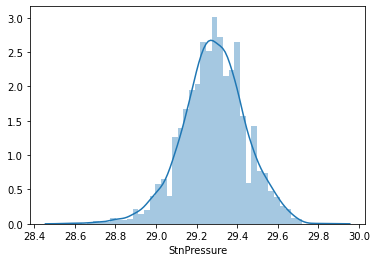

In [366]:
sns.distplot(weather.loc[(weather.StnPressure != 'M'), 'StnPressure'].map(lambda x : float(x)))

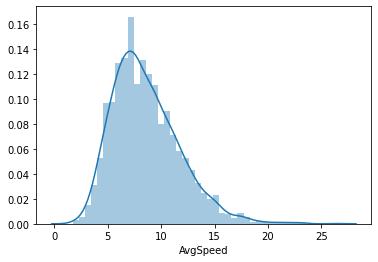

In [367]:
sns.distplot(weather.loc[(weather.AvgSpeed != 'M'), 'AvgSpeed'].map(lambda x : float(x)))

In [368]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')


weather.StnPressure = weather.StnPressure.map(lambda x : np.nan if x == 'M' else x)
weather.AvgSpeed = weather.AvgSpeed.map(lambda x : np.nan if x == 'M' else x)

weather.StnPressure = imp_mean.fit_transform(weather.StnPressure.values.reshape(-1, 1))
weather.AvgSpeed = imp_mean.fit_transform(weather.AvgSpeed.values.reshape(-1, 1))

In [369]:
weather.head(100)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WeekofYear
0,1,2007-05-01,83,50,66.5,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,5,18
1,2,2007-05-01,84,52,68.0,M,51,57,0,3,...,M,0.00,29.18,29.82,2.7,25,9.6,2007,5,18
2,1,2007-05-02,59,42,50.5,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,5,18
3,2,2007-05-02,60,43,51.5,M,42,47,13,0,...,M,0.00,29.44,30.08,13.3,2,13.4,2007,5,18
4,1,2007-05-03,66,46,56.0,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,2007-06-17,91,71,81.0,M,65,70,0,16,...,M,0.16,29.28,29.93,4.0,11,6.1,2007,6,24
96,1,2007-06-18,89,69,79.0,9,65,70,0,14,...,0.0,0.28,29.12,29.84,14.0,20,15.1,2007,6,25
97,2,2007-06-18,89,73,81.0,M,65,70,0,16,...,M,0.02,29.19,29.83,12.2,20,12.6,2007,6,25
98,1,2007-06-19,80,65,72.5,3,55,63,0,8,...,0.0,0.58,29.26,29.95,10.7,28,11.4,2007,6,25


### Observing differences between Weather Station 1 and Weather Station 2
---

Since there are 2 weather stations capturing the weather statistics each day, we will explore the differences in the data captured for each station, mainly focusing on the columns "Tavg" and "PrecipTotal" which are likely to provide the most meaningful information on mosquito propogation and lifespan.

From the graphs plotted below, there are in fact discrepancies between the data captured which may likely be due to the difference in distance between the 2 stations. However, the discrepancies between the 2 weather stations seem to be insignificant visually especially from the graph showing the average temperature. It can be concluded that the weather data from btoh stations can be combined and an average of the values can be taken.

In [370]:
weather['Year'] = weather['Date'].apply(lambda x:x.year).astype(float)
weather['Month'] = weather['Date'].apply(lambda x:x.month).astype(float)
weather['WeekofYear'] = weather['Date'].apply(lambda x:x.weekofyear).astype(float)
weather['WetBulb'] = weather['WetBulb'].apply(lambda x: np.nan if x == 'M' else x).astype(float)

In [371]:
weather.Date[0].month

5

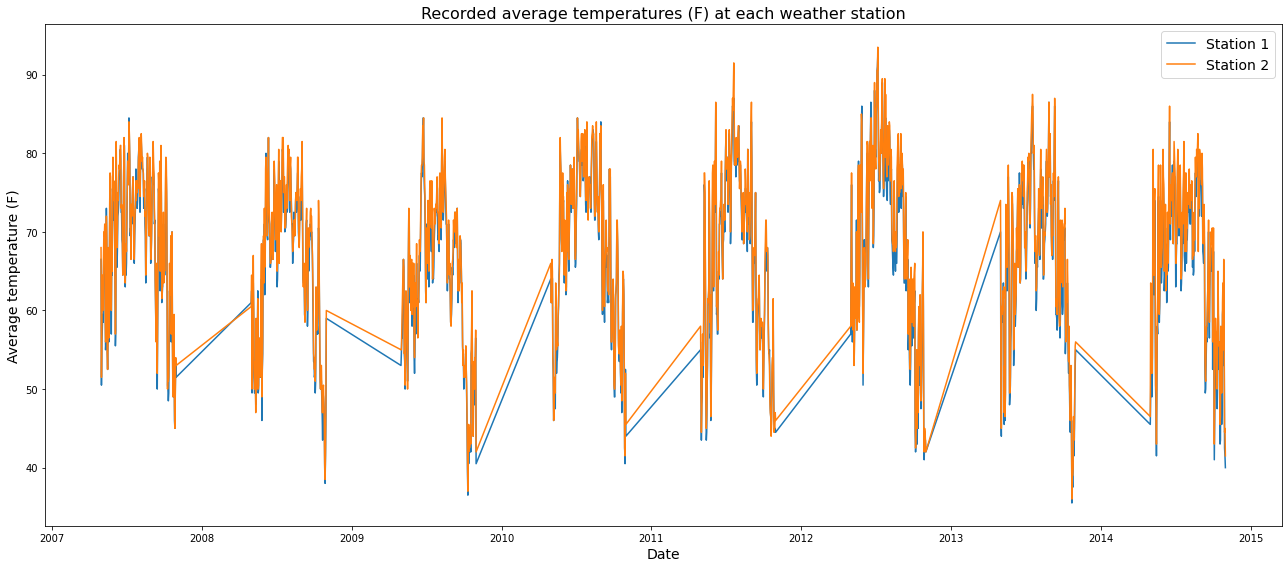

In [372]:
# plot all temperature information by station
plt.figure(figsize=(18,8))
sns.lineplot(x = weather.Date,y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = weather.Date,y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Recorded average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
#plt.xlim(weather.Month.min(), weather.Month.max())
plt.tight_layout()

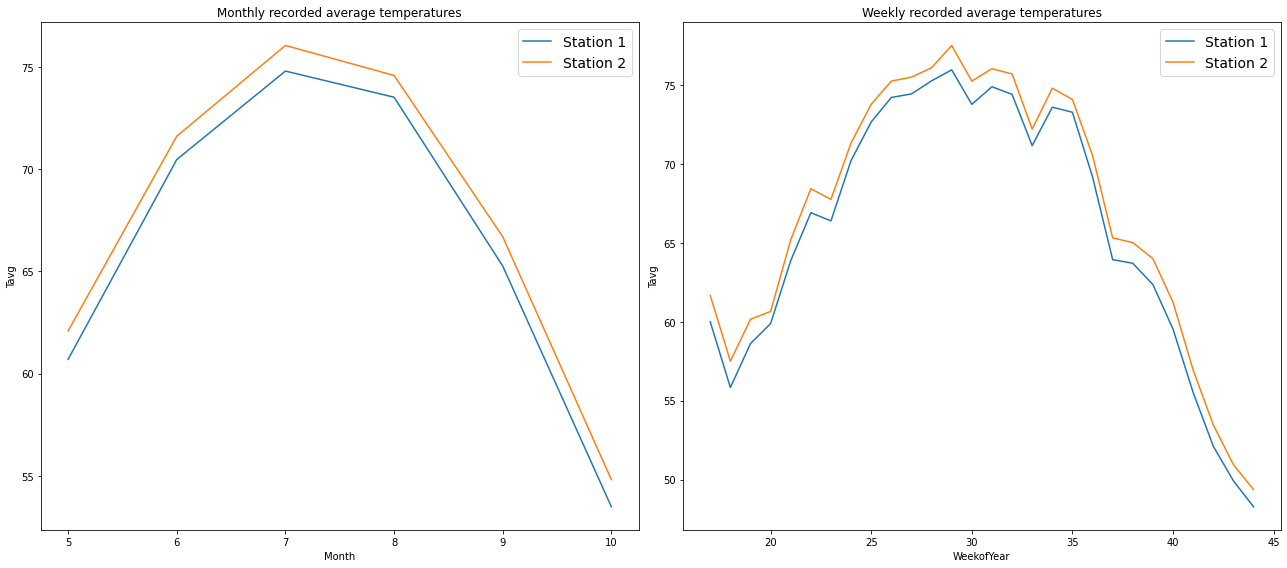

In [373]:
fig,  ax = plt.subplots(ncols = 2, figsize = (18,8))

#fig.suptitle('Monthy and weekly recorded average temperatures at both weather stations', fontsize=16)

ax[1].title.set_text('Weekly recorded average temperatures')
sns.lineplot(x = 'WeekofYear',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1", ax=ax[1])
sns.lineplot(x = 'WeekofYear',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2", ax =ax[1])
ax[1].legend(fontsize = 14)

ax[0].title.set_text('Monthly recorded average temperatures')
sns.lineplot(x = 'Month',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1", ax = ax[0])
sns.lineplot(x = 'Month',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2", ax =ax[0])
ax[0].legend(fontsize = 14)

plt.tight_layout()

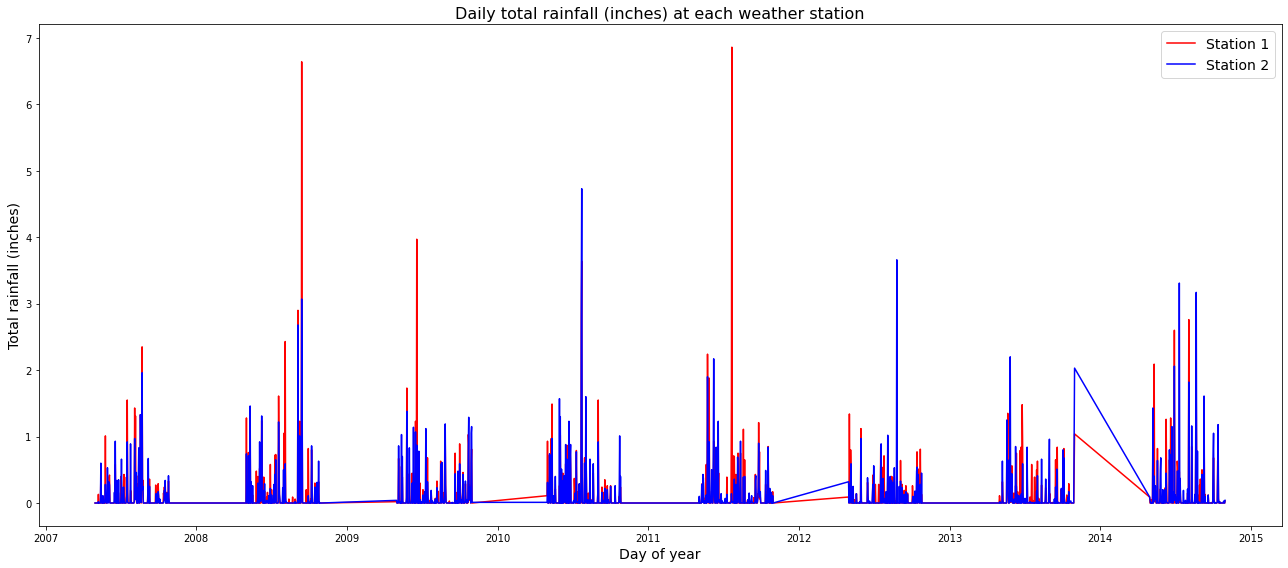

In [374]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = weather.Date,y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1", color = 'red')
sns.lineplot(x = weather.Date,y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2", color = 'blue')
plt.legend(fontsize = 14)
plt.title('Daily total rainfall (inches) at each weather station', fontsize=16)
plt.xlabel('Day of year',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
#plt.xlim(weather.WeekofYear.min(), weather.WeekofYear.max())
plt.tight_layout()

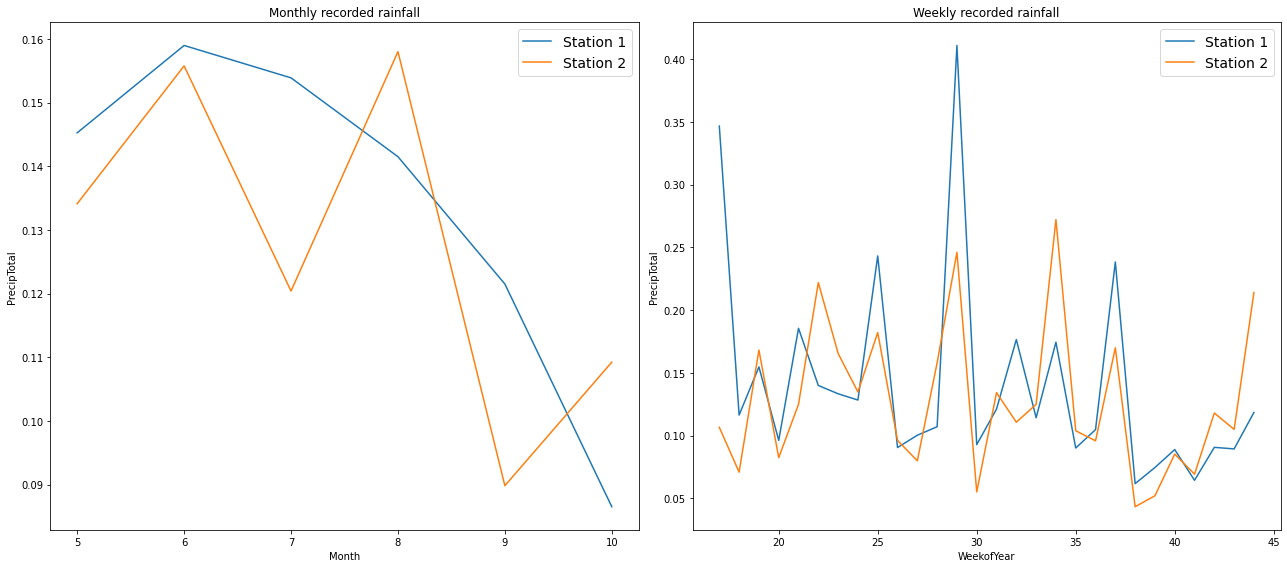

In [375]:
fig,  ax = plt.subplots(ncols = 2, figsize = (18,8))

#fig.suptitle('Monthy and weekly recorded average temperatures at both weather stations', fontsize=16)

ax[1].title.set_text('Weekly recorded rainfall')
sns.lineplot(x = 'WeekofYear',y = 'PrecipTotal', data = weather[weather.Station==1], ci = None, label = "Station 1", ax=ax[1])
sns.lineplot(x = 'WeekofYear',y = 'PrecipTotal', data = weather[weather.Station==2], ci = None, label = "Station 2", ax =ax[1])
ax[1].legend(fontsize = 14)

ax[0].title.set_text('Monthly recorded rainfall')
sns.lineplot(x = 'Month',y = 'PrecipTotal', data = weather[weather.Station==1], ci = None, label = "Station 1", ax = ax[0])
sns.lineplot(x = 'Month',y = 'PrecipTotal', data = weather[weather.Station==2], ci = None, label = "Station 2", ax =ax[0])
ax[0].legend(fontsize = 14)

plt.tight_layout()

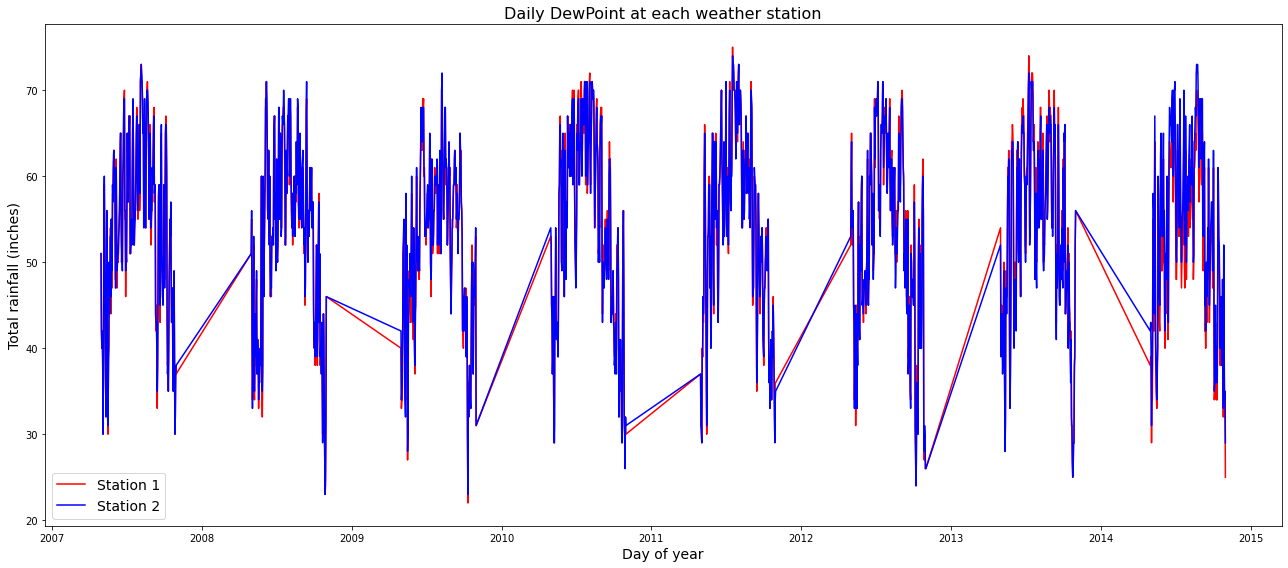

In [376]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = weather.Date,y = 'DewPoint',data = weather[weather.Station==1],ci = None,label = "Station 1", color = 'red')
sns.lineplot(x = weather.Date,y = 'DewPoint',data = weather[weather.Station==2],ci = None,label = "Station 2", color = 'blue')
plt.legend(fontsize = 14)
plt.title('Daily DewPoint at each weather station', fontsize=16)
plt.xlabel('Day of year',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
#plt.xlim(weather.WeekofYear.min(), weather.WeekofYear.max())
plt.tight_layout()

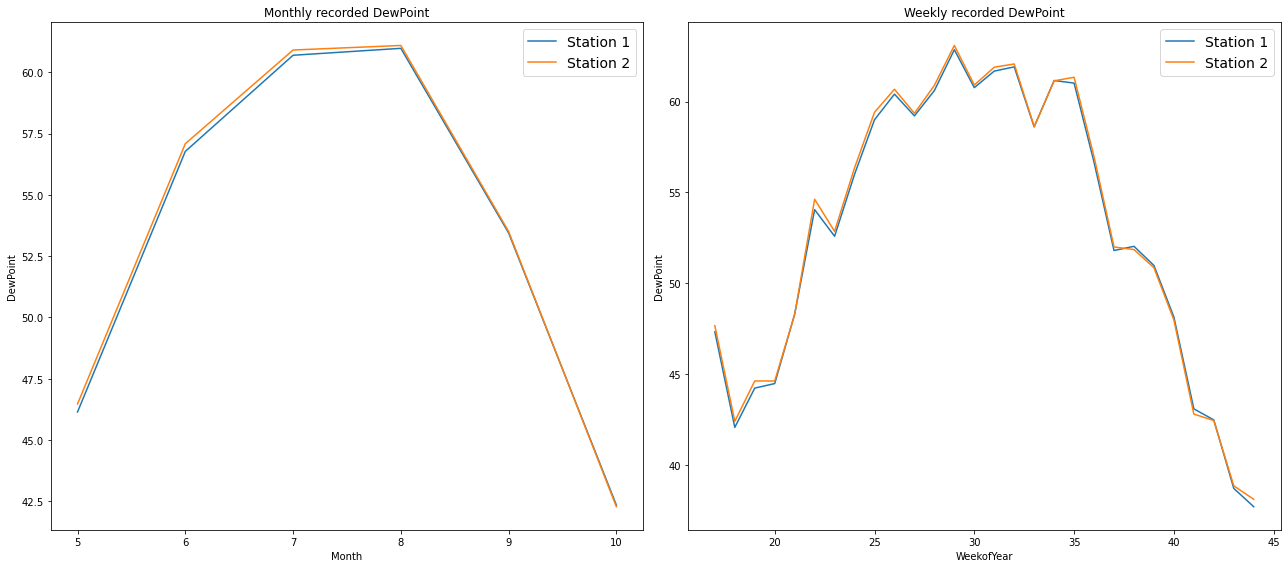

In [377]:
fig,  ax = plt.subplots(ncols = 2, figsize = (18,8))

#fig.suptitle('Monthy and weekly recorded average temperatures at both weather stations', fontsize=16)

ax[1].title.set_text('Weekly recorded DewPoint')
sns.lineplot(x = 'WeekofYear',y = 'DewPoint', data = weather[weather.Station==1], ci = None, label = "Station 1", ax=ax[1])
sns.lineplot(x = 'WeekofYear',y = 'DewPoint', data = weather[weather.Station==2], ci = None, label = "Station 2", ax =ax[1])
ax[1].legend(fontsize = 14)

ax[0].title.set_text('Monthly recorded DewPoint')
sns.lineplot(x = 'Month',y = 'DewPoint', data = weather[weather.Station==1], ci = None, label = "Station 1", ax = ax[0])
sns.lineplot(x = 'Month',y = 'DewPoint', data = weather[weather.Station==2], ci = None, label = "Station 2", ax =ax[0])
ax[0].legend(fontsize = 14)

plt.tight_layout()

In [378]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month', 'WeekofYear'],
      dtype='object')

### Combine data from 2 weather stations and further eda

In this section, the weather data from both stations are combined and an average of their values are taken as the final weather data to be appended to our train data set. Further EDA was conducted to observe the weather data in terms of distribution plots and boxplots, however, no obvious telling trends can be observed.

Further line plots of weather parameters reveal that other than mean temperatures and wind speed, atmospheric pressure and rainfall show fairly erratic patterns throughout the active sample months and are unlikely to be effective predictors. 

Correlation heatmaps also does not reveal any strong positive or negative correlations with `Wnv_present` to draw obvious trends.

In [379]:
# combine data from the 2 weather stations
weather_combined = weather.groupby('Date').mean()
weather_combined.drop(['Station', 'Year','Month','WeekofYear'],axis=1,inplace=True)
weather_combined.reset_index(inplace=True)

In [380]:
# adding year/month/week columns back as they were previously affected by the groupby function and removed
weather_combined['year'] = weather_combined['Date'].apply(lambda x:x.year)
weather_combined['month'] = weather_combined['Date'].apply(lambda x:x.month)
weather_combined['weekofyear'] = weather_combined['Date'].apply(lambda x:x.weekofyear)

In [381]:
weather_combined.head()

,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,year,month,weekofyear
0,2007-05-01,83.5,51.0,67.25,51.0,56.5,0.0,29.140,2.20,26.0,9.40,2007,5,18
1,2007-05-02,59.5,42.5,51.00,42.0,47.0,0.0,29.410,13.15,3.0,13.40,2007,5,18
2,2007-05-03,66.5,47.0,56.75,40.0,49.0,0.0,29.425,12.30,6.5,12.55,2007,5,18
3,2007-05-04,72.0,50.0,61.00,41.5,50.0,0.0,29.335,10.25,7.5,10.60,2007,5,18
4,2007-05-05,66.0,53.5,59.75,38.5,49.5,0.0,29.430,11.45,7.0,11.75,2007,5,18


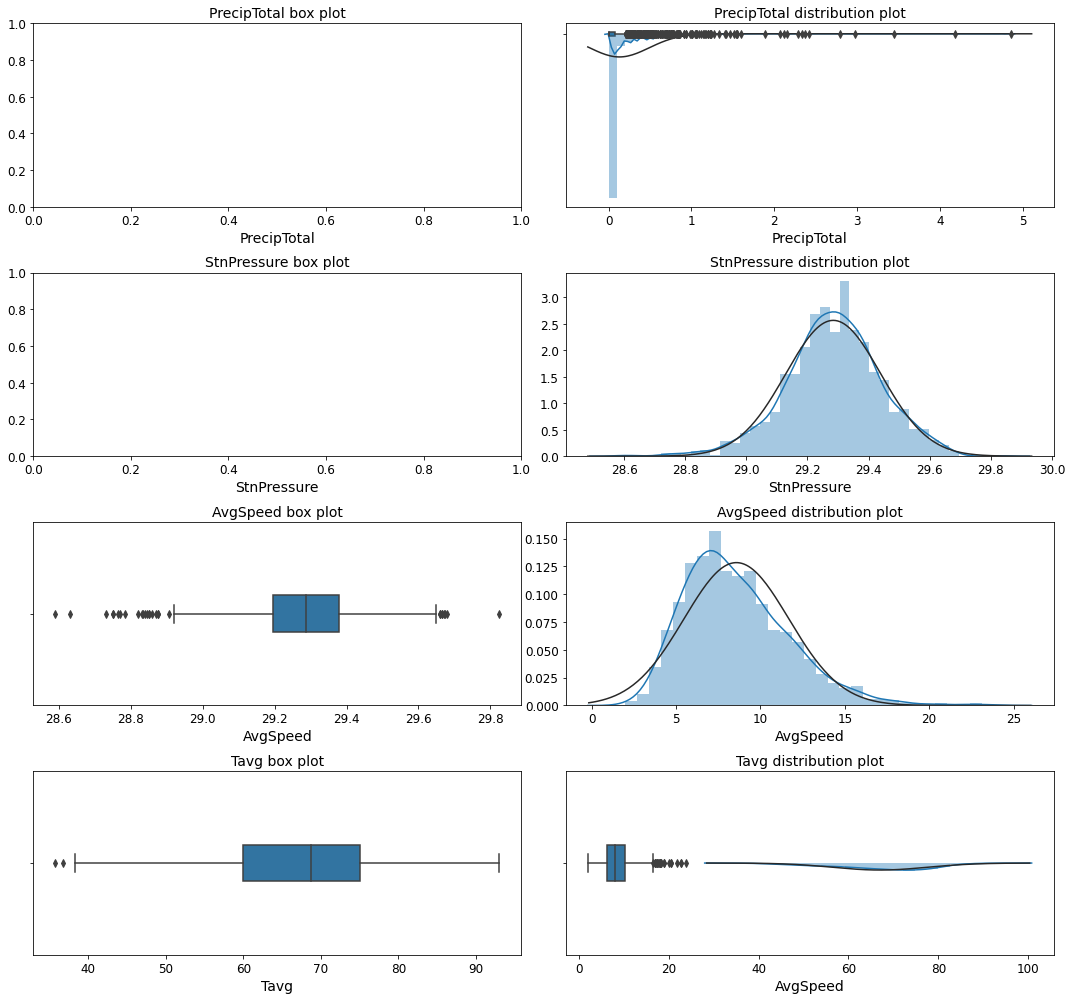

In [382]:
dist_plots(weather_combined,['Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed'])

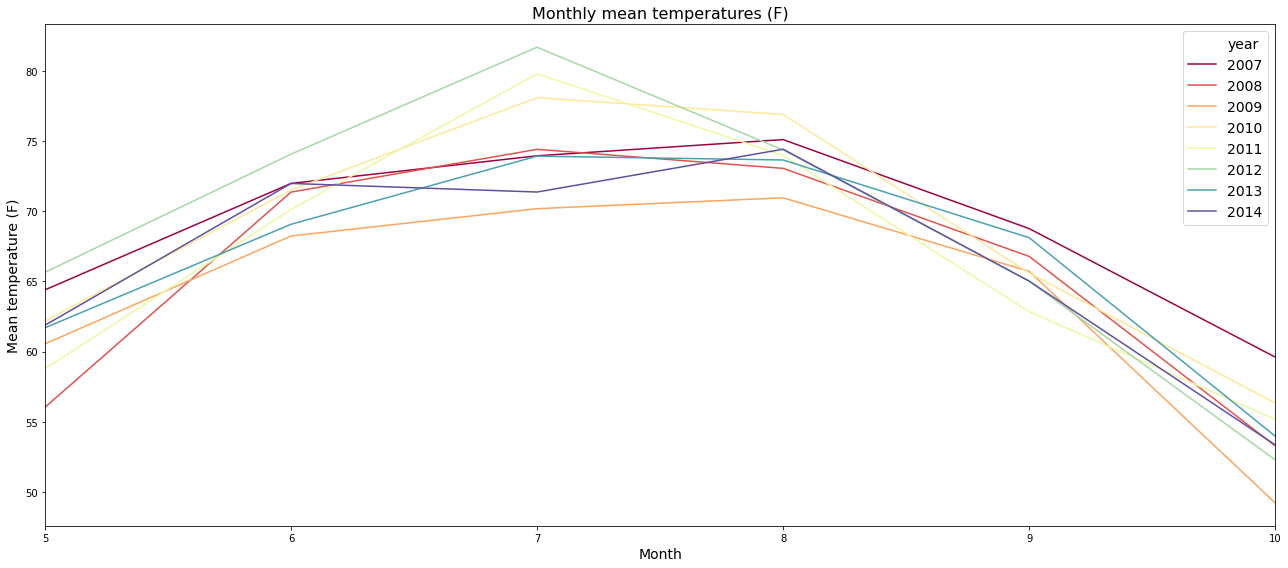

In [383]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'Tavg', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

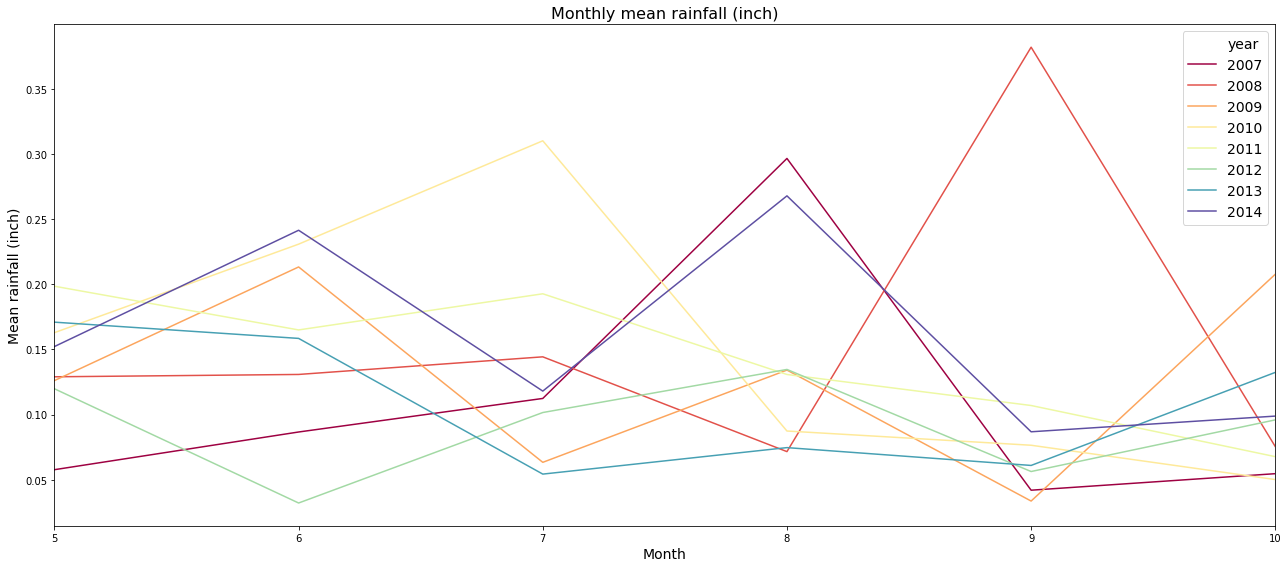

In [384]:
# plot rainfall by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'PrecipTotal', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean rainfall (inch)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean rainfall (inch)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

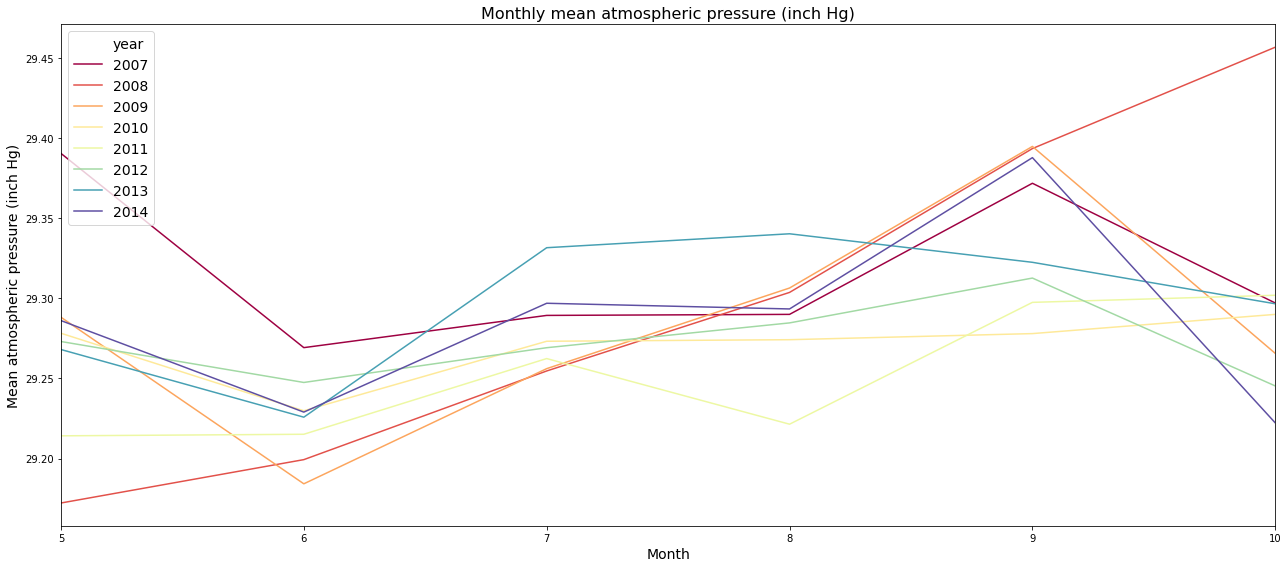

In [385]:
# plot atmospheric pressure by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'StnPressure', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean atmospheric pressure (inch Hg)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean atmospheric pressure (inch Hg)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

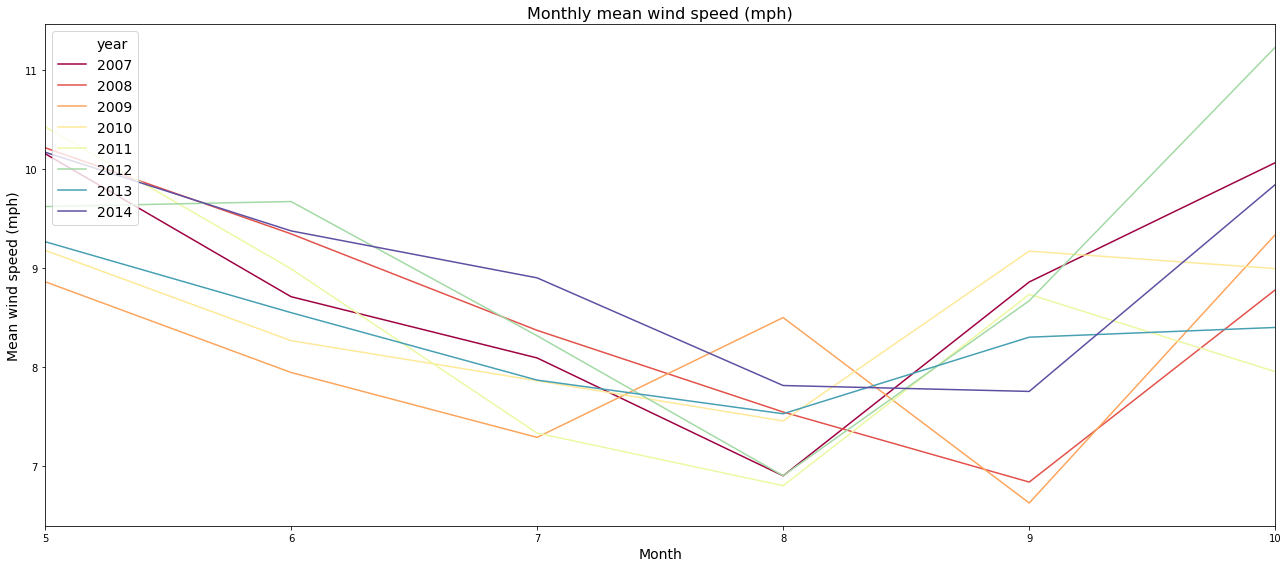

In [386]:
# plot wind speed by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'AvgSpeed', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean wind speed (mph)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean wind speed (mph)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

## Merge weather and train data

In [387]:
train.reset_index(inplace= True)

station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
train['Nearest_Station'] = train['geometry'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)

train['Date_Station'] = train['Date'].astype(str) + '_' + train['Nearest_Station'].astype(str)

train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth,NumMosquitos,WnvPresent,geometry,Nearest_Station,Date_Station
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,1,0,POINT (-87.65422 41.86711),2,2007-05-29_2
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2007,5,22,2007-05,2,0,POINT (-87.65422 41.86711),2,2007-05-29_2
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,2007,5,22,2007-05,1,0,POINT (-87.64886 41.86229),2,2007-05-29_2
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,2007,5,22,2007-05,1,0,POINT (-87.65523 41.89628),2,2007-05-29_2
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,2007,5,22,2007-05,1,0,POINT (-87.76089 41.90765),2,2007-05-29_2


In [388]:
combined = pd.merge(train, weather, how='inner', on='Date')

combined.columns

combined.drop(['Year_x','Month_x','WeekofYear_x'], axis=1, inplace=True)

combined.rename({"Year_y":"Year",
               "Month_y":"Month",
               "WeekofYear_y":"WeekofYear"},
               axis = 1,
               inplace = True)

combined.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'YearMonth', 'NumMosquitos', 'WnvPresent', 'geometry',
       'Nearest_Station', 'Date_Station', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month',
       'WeekofYear'],
      dtype='object')

### Columns to drop
---
Upon further examination of the different features, a umber of features appear fairly erroneous and we have decided to drop them. Features such as `Tmax` and `Tmin` have proper representation in features such as `Tavg` and any address-related feature that cannot be one-hot-encoded can be dropped.

In [389]:
cols_to_drop = ['Address', 'Street', 'Block', 'AddressAccuracy', 'geometry', 
                'Date_Station', 'Tmax', 'Tmin', 'Depart', 'Heat', 'Cool', 'Sunrise',
                'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'SeaLevel', 'ResultSpeed',
                'ResultDir', 'YearMonth', 'AddressNumberAndStreet']

In [390]:
combined.drop(cols_to_drop, axis=1, inplace =True)

## Correlation heatmap

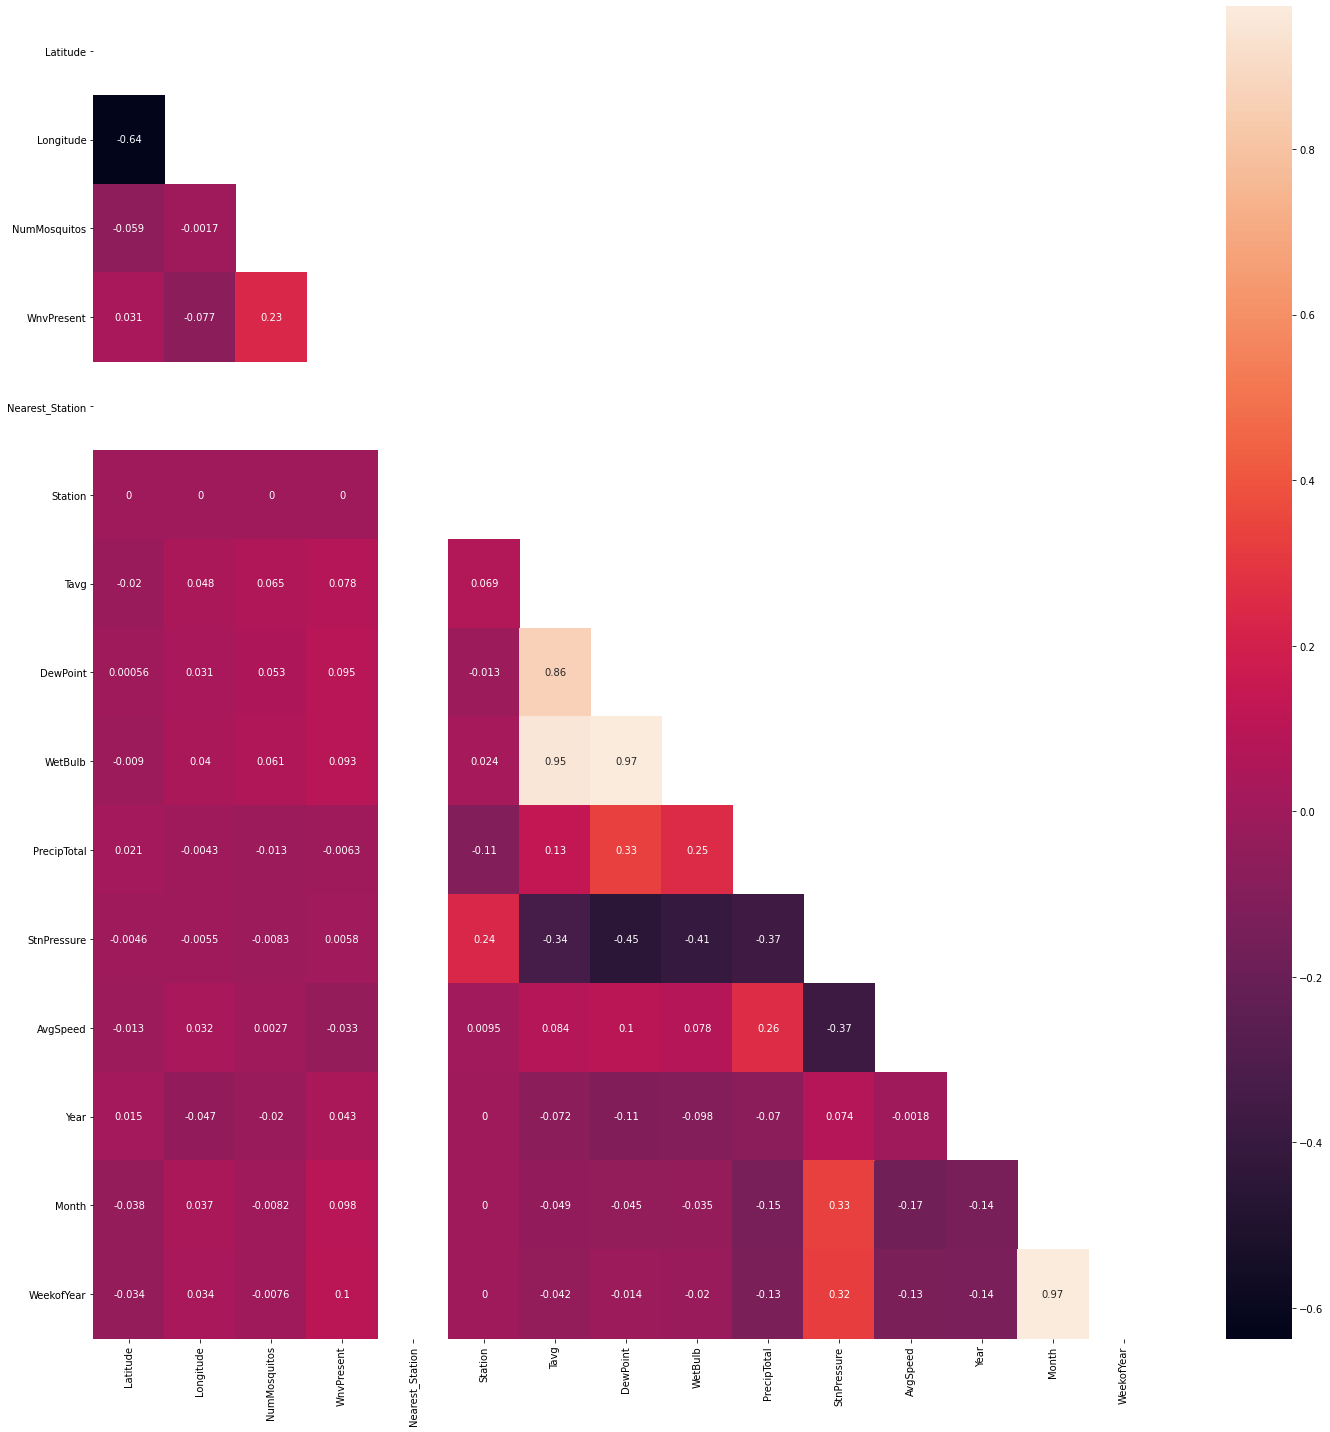

In [391]:
plt.figure(figsize=(20,20))
corr = combined.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, mask=mask, annot = True)
plt.tight_layout()

## Test data processing

In [392]:
test.isnull().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

In [393]:
# Create new datetime columns
test['Year'] = test['Date'].apply(lambda x:x.year)
test['Month'] = test['Date'].apply(lambda x:x.month)
test['WeekofYear'] = test['Date'].apply(lambda x:x.weekofyear)
test['YearMonth'] = test['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

In [394]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Year,Month,WeekofYear,YearMonth
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,24,2008-06
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,24,2008-06
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,24,2008-06
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,24,2008-06
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,24,2008-06


In [395]:
combined_test = pd.merge(test, weather, how='inner', on='Date')

combined_test.columns

combined_test.drop(['Year_x','Month_x','WeekofYear_x'], axis=1, inplace=True)

combined_test.rename({"Year_y":"Year",
               "Month_y":"Month",
               "WeekofYear_y":"WeekofYear"},
               axis = 1,
               inplace = True)

combined_test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'YearMonth', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month', 'WeekofYear'],
      dtype='object')

In [396]:
cols_to_drop_test = ['Address', 'Street', 'Block', 'AddressAccuracy', 
                'Tmax', 'Tmin', 'Depart', 'Heat', 'Cool', 'Sunrise',
                'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'SeaLevel', 'ResultSpeed',
                'ResultDir', 'YearMonth', 'AddressNumberAndStreet']

In [397]:
combined_test.drop(cols_to_drop_test, axis=1, inplace =True)

In [398]:
combined_test.head()

,Id,Date,Species,Trap,Latitude,Longitude,Station,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,AvgSpeed,Year,Month,WeekofYear
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1,73.5,56,64.0,0.0,29.28,10.0,2008.0,6.0,24.0
1,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2,76.0,55,64.0,0.0,29.34,10.4,2008.0,6.0,24.0
2,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,1,73.5,56,64.0,0.0,29.28,10.0,2008.0,6.0,24.0
3,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2,76.0,55,64.0,0.0,29.34,10.4,2008.0,6.0,24.0
4,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,1,73.5,56,64.0,0.0,29.28,10.0,2008.0,6.0,24.0


In [401]:
combined.dtypes

Date               datetime64[ns]
Species                    object
Trap                       object
Latitude                  float64
Longitude                 float64
NumMosquitos                int64
WnvPresent                  int64
Nearest_Station             int64
Station                     int64
Tavg                      float64
DewPoint                    int64
WetBulb                   float64
PrecipTotal               float64
StnPressure               float64
AvgSpeed                  float64
Year                      float64
Month                     float64
WeekofYear                float64
dtype: object

In [402]:
combined.dtypes

Date               datetime64[ns]
Species                    object
Trap                       object
Latitude                  float64
Longitude                 float64
NumMosquitos                int64
WnvPresent                  int64
Nearest_Station             int64
Station                     int64
Tavg                      float64
DewPoint                    int64
WetBulb                   float64
PrecipTotal               float64
StnPressure               float64
AvgSpeed                  float64
Year                      float64
Month                     float64
WeekofYear                float64
dtype: object

In [403]:
combined_test.dtypes

Id                      int64
Date           datetime64[ns]
Species                object
Trap                   object
Latitude              float64
Longitude             float64
Station                 int64
Tavg                  float64
DewPoint                int64
WetBulb               float64
PrecipTotal           float64
StnPressure           float64
AvgSpeed              float64
Year                  float64
Month                 float64
WeekofYear            float64
dtype: object

In [404]:
#Check WetBulb missing values
combined.WetBulb.unique()

array([65., 66., 51., 52., 72., 59., 60., 58., 71., 67., 70., 69., 76.,
       73., 74., 68., 61., 62., 49., 50., 53., 54., 46., 48., 55., nan,
       63., 57., 56., 64., 75., 47.])

In [405]:
#Fill WetBulb nan values with 0.0
combined.WetBulb.fillna(0.0, inplace = True)

In [406]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16950 entries, 0 to 16949
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             16950 non-null  datetime64[ns]
 1   Species          16950 non-null  object        
 2   Trap             16950 non-null  object        
 3   Latitude         16950 non-null  float64       
 4   Longitude        16950 non-null  float64       
 5   NumMosquitos     16950 non-null  int64         
 6   WnvPresent       16950 non-null  int64         
 7   Nearest_Station  16950 non-null  int64         
 8   Station          16950 non-null  int64         
 9   Tavg             16950 non-null  float64       
 10  DewPoint         16950 non-null  int64         
 11  WetBulb          16950 non-null  float64       
 12  PrecipTotal      16950 non-null  float64       
 13  StnPressure      16950 non-null  float64       
 14  AvgSpeed         16950 non-null  float

In [407]:
combined_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232586 entries, 0 to 232585
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Id           232586 non-null  int64         
 1   Date         232586 non-null  datetime64[ns]
 2   Species      232586 non-null  object        
 3   Trap         232586 non-null  object        
 4   Latitude     232586 non-null  float64       
 5   Longitude    232586 non-null  float64       
 6   Station      232586 non-null  int64         
 7   Tavg         232586 non-null  float64       
 8   DewPoint     232586 non-null  int64         
 9   WetBulb      232586 non-null  float64       
 10  PrecipTotal  232586 non-null  float64       
 11  StnPressure  232586 non-null  float64       
 12  AvgSpeed     232586 non-null  float64       
 13  Year         232586 non-null  float64       
 14  Month        232586 non-null  float64       
 15  WeekofYear   232586 non-null  floa

## Export processed datasets

In [408]:
# process train data
combined.to_csv('../assets/processed_train.csv')
combined_test.to_csv('../assets/processed_test.csv')